In [4]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
train_data_path = "~/aiffel/kaggle_kakr_housing/data/data/train.csv"
sub_data_path = "~/aiffel/kaggle_kakr_housing/data/data/test.csv"

## 1. 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [6]:
train = pd.read_csv(train_data_path)
test = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(train.shape))
print('sub data dim : {}'.format(test.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [7]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [8]:
# 총 데이터 개수
train.shape

(15035, 21)

In [9]:
# id가 unique 한가?
train.id.nunique()

15035

총 데이터 수와 id의 수가 같은 것을 보니 모든 id는 unique하다.

In [10]:
train.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

* id는 집 가격을 구하는데 전혀 필요가 없을 것으로 예상된다.
* date는 연도와 월 일만 남겨 사용할 수 있을 것 같다. 
* 화장실이 왜 소수점으로 나눠지는지 제대로 알아봐야겠다.
* 지하실의 평방피트 데이터는 지하실의 유무를 알아낼 수 도 있을 것 같다.
* 집의 나이 - 재개발의 유무를 나눠서 집의 나이를 계산해 살펴볼 수도 있을것같다. 
* 집의 위치에 따라 가격이 달라질 것으로 예상이 된다 이것은 zipcode와 lat, long으로 알아볼 수 있을 것 같다.
* 15년기준 주거지 평방피트, 부지 평방피트 와 일반 거주 평방피트와 부지 평방피트도 살펴봐야할 것 같다.
* condition, grade, view, waterfront 는 범주형으로 보인다.
* 층수에서 0.5는 주택의 제일 위쪽 삼각형 지붕 밑의 공간을 의미하므로 floors에서 floors를 정수 층수로 만들고 소수점 부분을 다락방의 유무 특징을 넣어도 될 것이라고 생각함.

### 모든id가 unique한지 확인 후 제거하기

In [11]:
# id라는 feature는 필요없을 것으로 보이므로 id를 다른 변수에 저장해두고 train, test data에서는 빼기로 하자
train_id = train['id']
test_id = test['id']

del train['id']
del test['id']

In [12]:
train.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [13]:
test.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


### Date column을 연,월,일,요일, 쿼터로 나누기

In [14]:
# date를 연도,월,일만 남겨 사용하기
train['date'] = pd.to_datetime(train['date'])
train.dtypes

date             datetime64[ns]
price                   float64
bedrooms                  int64
bathrooms               float64
sqft_living               int64
sqft_lot                  int64
floors                  float64
waterfront                int64
view                      int64
condition                 int64
grade                     int64
sqft_above                int64
sqft_basement             int64
yr_built                  int64
yr_renovated              int64
zipcode                   int64
lat                     float64
long                    float64
sqft_living15             int64
sqft_lot15                int64
dtype: object

In [15]:
train.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,2014-06-27,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,2015-01-15,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [16]:
test['date'] = pd.to_datetime(test['date'])
test.dtypes

date             datetime64[ns]
bedrooms                  int64
bathrooms               float64
sqft_living               int64
sqft_lot                  int64
floors                  float64
waterfront                int64
view                      int64
condition                 int64
grade                     int64
sqft_above                int64
sqft_basement             int64
yr_built                  int64
yr_renovated              int64
zipcode                   int64
lat                     float64
long                    float64
sqft_living15             int64
sqft_lot15                int64
dtype: object

In [17]:
test.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,2014-12-09,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,2014-12-09,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,2014-05-12,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,2015-04-15,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,2015-03-12,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


In [18]:
def split_YMD(data):
    data['year'] = data.date.dt.year
    data['month'] = data.date.dt.month
    data['day'] = data.date.dt.day
    data['day_of_week'] = data.date.dt.day_of_week
    data['quarter'] = data.date.dt.quarter
    
    data.drop('date', axis = 1, inplace = True)

In [19]:
split_YMD(train)
split_YMD(test)

In [20]:
train.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day,day_of_week,quarter
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,...,98178,47.5112,-122.257,1340,5650,2014,10,13,0,4
1,180000.0,2,1.00,770,10000,1.0,0,0,3,6,...,98028,47.7379,-122.233,2720,8062,2015,2,25,2,1
2,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,...,98074,47.6168,-122.045,1800,7503,2015,2,18,2,1
3,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,...,98003,47.3097,-122.327,2238,6819,2014,6,27,4,2
4,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,...,98198,47.4095,-122.315,1650,9711,2015,1,15,3,1


In [21]:
test.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day,day_of_week,quarter
0,3,2.25,2570,7242,2.0,0,0,3,7,2170,...,98125,47.7210,-122.319,1690,7639,2014,12,9,1,4
1,4,3.00,1960,5000,1.0,0,0,5,7,1050,...,98136,47.5208,-122.393,1360,5000,2014,12,9,1,4
2,4,4.50,5420,101930,1.0,0,0,3,11,3890,...,98053,47.6561,-122.005,4760,101930,2014,5,12,0,2
3,3,1.00,1780,7470,1.0,0,0,3,7,1050,...,98146,47.5123,-122.337,1780,8113,2015,4,15,2,2
4,3,2.50,1890,6560,2.0,0,0,3,7,1890,...,98038,47.3684,-122.031,2390,7570,2015,3,12,3,1


# Data Preprocess

### 결측치 확인

<AxesSubplot:>

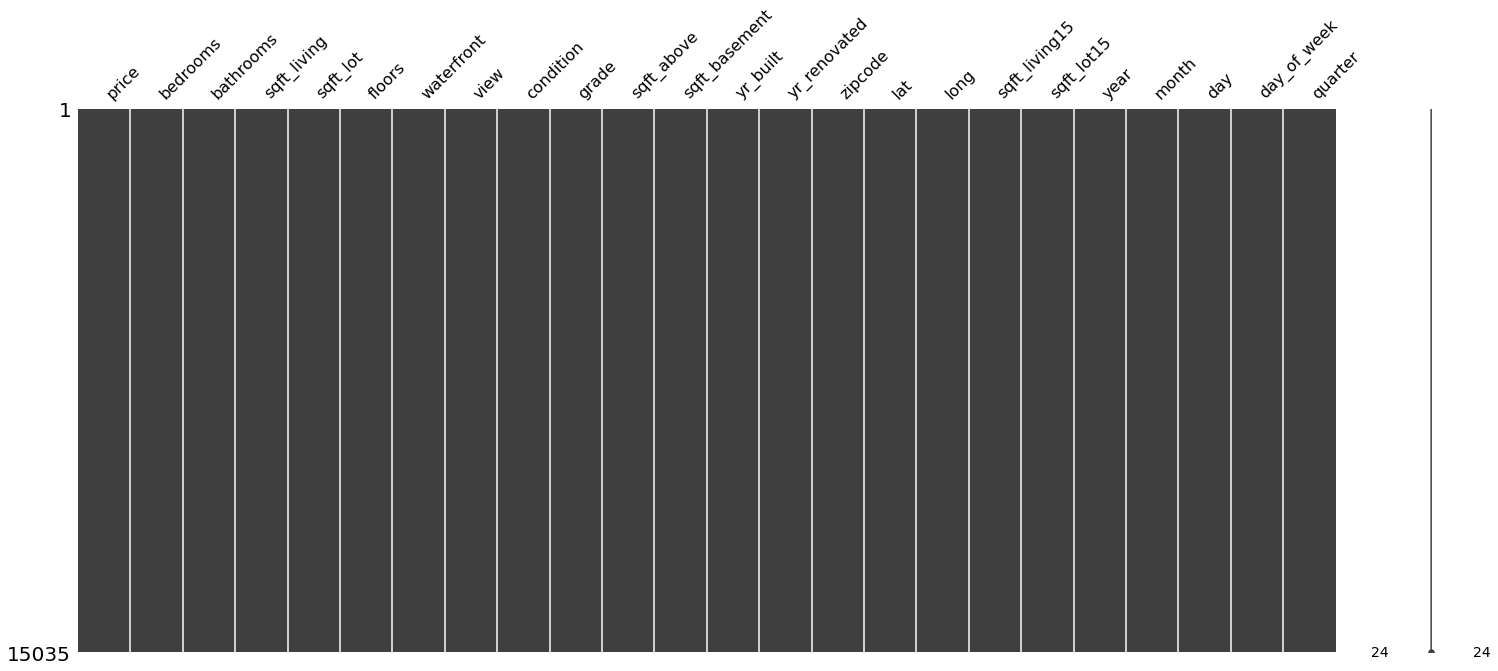

In [23]:
msno.matrix(train)

### Date에 따른 판매량 분석

In [24]:
date_columns = ["year", "month", 'day', 'day_of_week', 'quarter']

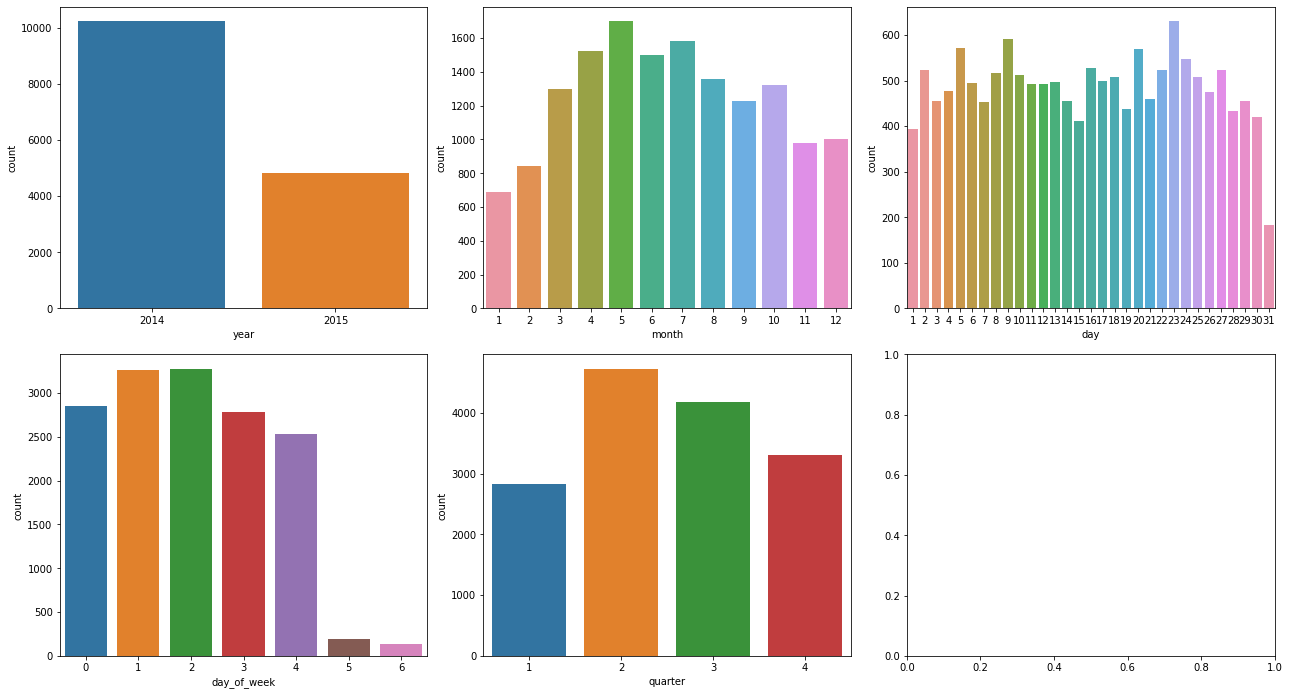

In [25]:
columns = [""]
fig, axes = plt.subplots(2,3)
fig.set_size_inches(18,10)
fig.tight_layout(pad=2.5)
for i in range(6):
    if i == 5:
        break
    sns.countplot(data = train, x = train[date_columns[i]], ax= axes[i//3, i%3])


* 2014년보다 2015년의 데이터가 적은 것으로는 데이터 분석이 어려울 것 같다
* 11 - 2 월 사이가 데이터량이 적은 것으로 보아 3- 10월 사이가 집이 많이 팔린 것 같다.
* 일로는 큰 데이터 분석이 어렵다
* 주말보다는 평일에 집이 많이 팔린 것으로 생각된다.
* 2분기에 가장 판매량이 높고 3분기 그리고 4분기가 판매량이 높고 1분기가 가장 판매량이 적다.
* 따라서 연도와 날은 집값 예측에 영향을 미치지 못할 것으로 보인다.
* 날짜에 따른 집이 팔린 데이터 수로는 집 값을 예측하기는 어려울 것으로 파악.

### 방 개수와 방에 따른 화장실 개수를 확인해보자

<AxesSubplot:xlabel='bathrooms', ylabel='count'>

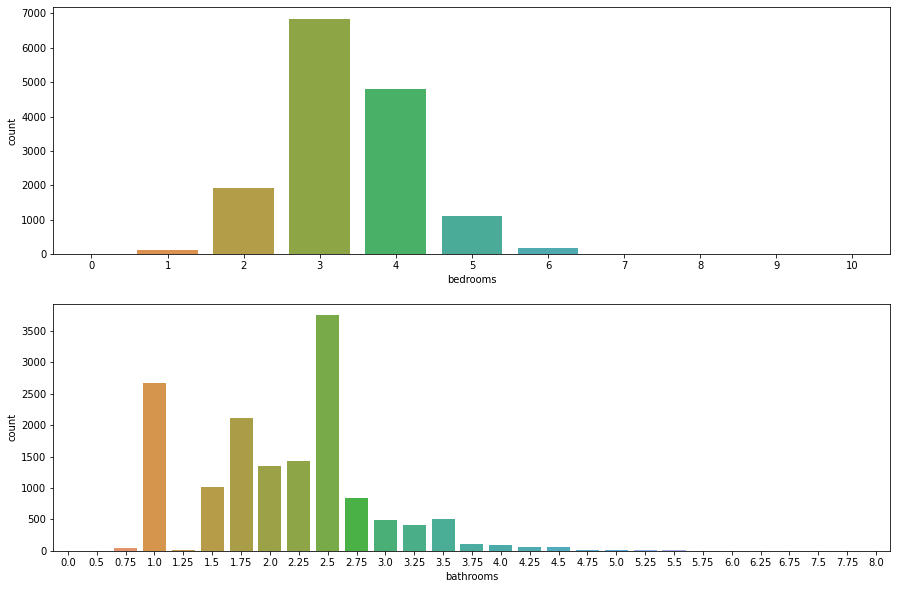

In [26]:
fig, (ax1, ax2) = plt.subplots(2,1)
fig.set_size_inches(15,10)
sns.countplot(data = train, x = train['bedrooms'], ax = ax1)
sns.countplot(data = train, x = train['bathrooms'], ax = ax2)

In [27]:
print(len(train.loc[train.bedrooms == 7]))
print(len(train.loc[train.bedrooms == 8]))
print(len(train.loc[train.bedrooms == 9]))

22
10
5


In [28]:
for i in range(0, 9,1):
    print(f'# of bathrooms data between {i} and {i+1}: {len(train.loc[(train.bathrooms >= i) & (train.bathrooms < i+1)])}')
print(f'0 bathrooms: {len(train.loc[train.bathrooms == 0])}')

# of bathrooms data between 0 and 1: 52
# of bathrooms data between 1 and 2: 5801
# of bathrooms data between 2 and 3: 7381
# of bathrooms data between 3 and 4: 1521
# of bathrooms data between 4 and 5: 237
# of bathrooms data between 5 and 6: 35
# of bathrooms data between 6 and 7: 4
# of bathrooms data between 7 and 8: 2
# of bathrooms data between 8 and 9: 2
0 bathrooms: 4


In [29]:
sorted(train.bathrooms.unique())

[0.0,
 0.5,
 0.75,
 1.0,
 1.25,
 1.5,
 1.75,
 2.0,
 2.25,
 2.5,
 2.75,
 3.0,
 3.25,
 3.5,
 3.75,
 4.0,
 4.25,
 4.5,
 4.75,
 5.0,
 5.25,
 5.5,
 5.75,
 6.0,
 6.25,
 6.75,
 7.5,
 7.75,
 8.0]

<AxesSubplot:xlabel='bathrooms', ylabel='price'>

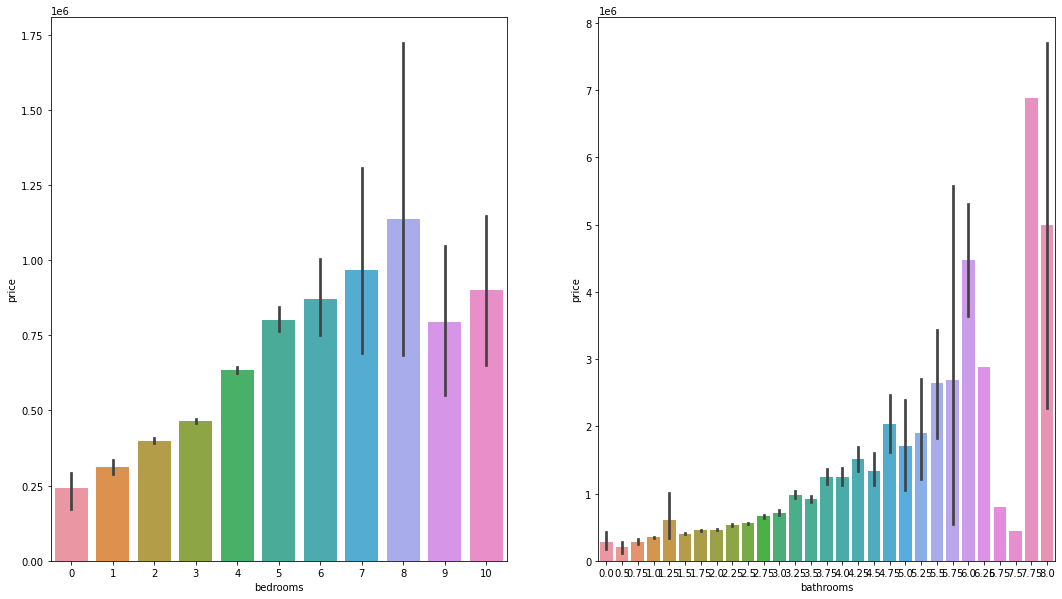

In [30]:
fig, ((ax1,ax2)) = plt.subplots(1,2)
fig.set_size_inches(18,10)
sns.barplot(data = train, x = 'bedrooms', y = 'price', ax = ax1)
sns.barplot(data = train, x = 'bathrooms', y = 'price', ax = ax2)

* 주로 방의 수가 많아질 수록 집값이 높아지나 방이 9개 이상이 되면 가격과 상관관계는 없어 보인다. 왜일까?
    * 방의 수가 많을 수록 데이터가 적어지는 것을 확인했고 또한 가격은 지역에 따라서 달라지기도 하기때문에 방이 많은 집이 집값이 싼 지역에 있을 수도 있겠다라고 생각을 했다. 예를 들어 뉴욕이나 서울같은 경우에는 집값이 비싸다 하지만 핵가구가 많기때문에 방의 수가 적은 것을 선호한다. 그리고 도시이기 때문에 매물도 많이 나간다. 반면 시골의 경우에는 대가족이 많은 편이다 보니 방의 수가 많은 경우도 있다 하지만 도시에 비해 가격이 싸지므로 많은 방이 있음에도 불구하고 가격이 싸지는 경우가 많다. 이러한 이유가 아닐까 예상해본다.
    * 따라서 이것은 집의 위치에 따라서 가격이 매우 차이날 것으로 생각된다.
* 화장실이 float으로 되어있는 이유가 무엇일까 찾아보았다
    * full bath : 화장실, 세면대, 샤워실, 욕조
    * 3/4 bath : 화장실, 세면대, 샤워실
    * half bath : 화장실, 세면대
* 따라서 1/2 bathroom과 3/4 bathroom이 있다면 1.25 bathroom이 되는 것이므로 full bath 3/4 bath, half bath로 나누는 것은 매우 어려워보인다. 
* 화장실이 0개인 집이 있다는것이 수상해보인다. 공동화장실이 있는 집일까? 이 부분에 대해선 굳이 파헤칠 필요가 없어보인다.

개인적인 생각으로는 방의 개수, 화장실의 개수 등의 집과 관련된 데이터들은 위치 데이터에 따라 가격이 천차만별일 것으로 예상이 된다.
따라서 위치데이터에 따른 방의개수, 화장실의 개수, 집의 평방피트, 부지의 평방 피트, 등에 대해서 알아보도록 하려고 한다.<br>
이 데이터는 미국을 바탕으로 만들어진 데이터라고 한다. 따라서 미국의 지도를 사용해볼 예정이다.

### sqft_living과 sqft_lot 데이터 분석
* 각 데이터량부터 보기

In [31]:
train['sqft_living'].describe()

count    15035.000000
mean      2083.790223
std        922.134087
min        290.000000
25%       1430.000000
50%       1910.000000
75%       2560.000000
max      13540.000000
Name: sqft_living, dtype: float64

In [32]:
train['sqft_lot'].describe()

count    1.503500e+04
mean     1.529697e+04
std      4.261282e+04
min      5.200000e+02
25%      5.027500e+03
50%      7.620000e+03
75%      1.069550e+04
max      1.651359e+06
Name: sqft_lot, dtype: float64

<AxesSubplot:xlabel='sqft_lot', ylabel='count'>

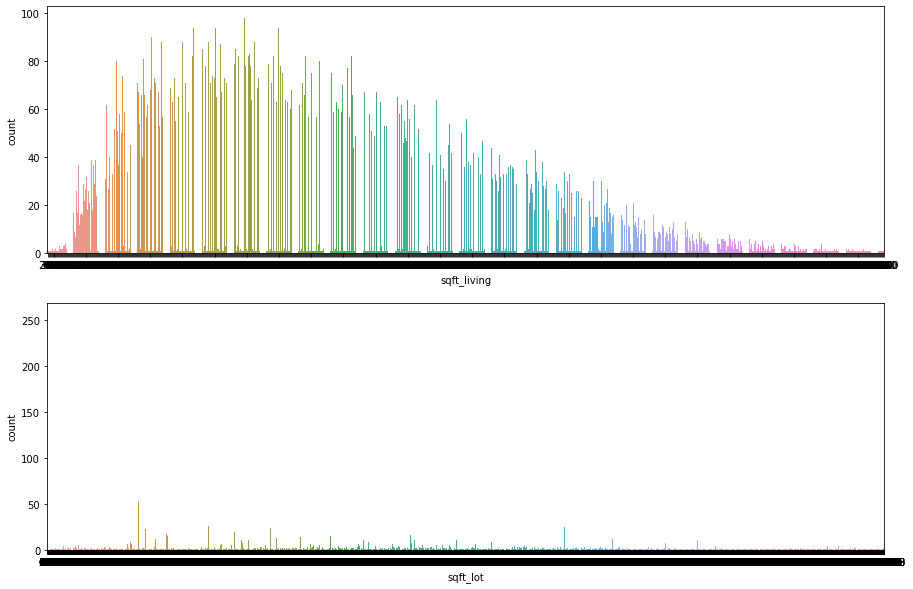

In [33]:
fig, (ax1, ax2) = plt.subplots(2,1)
fig.set_size_inches(15,10)
sns.countplot(data = train, x = train['sqft_living'], ax = ax1)
sns.countplot(data = train, x = train['sqft_lot'], ax = ax2)

<AxesSubplot:xlabel='sqft_lot', ylabel='price'>

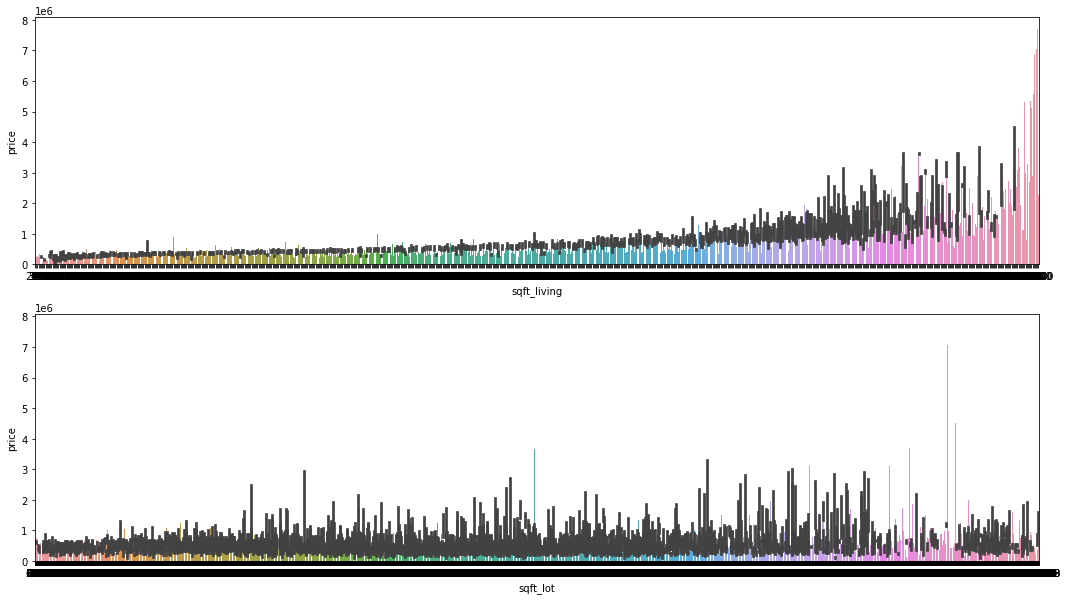

In [34]:
fig, (ax1,ax2) = plt.subplots(2,1)
fig.set_size_inches(18,10)
sns.barplot(data = train, x = 'sqft_living', y = 'price', ax = ax1)
sns.barplot(data = train, x = 'sqft_lot', y = 'price', ax = ax2)

<AxesSubplot:xlabel='sqft_lot', ylabel='price'>

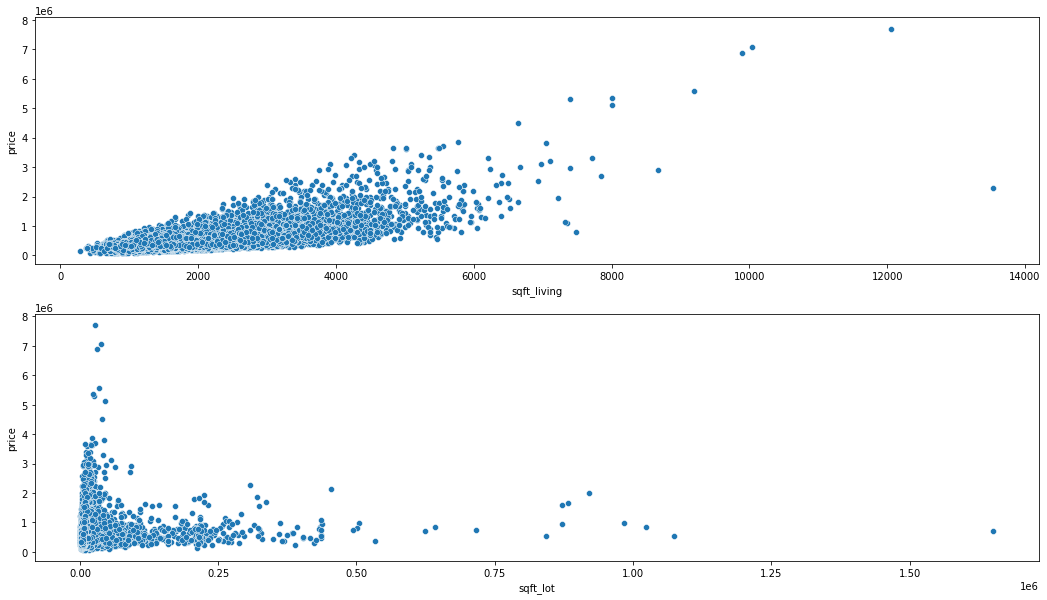

In [35]:
fig, (ax1,ax2) = plt.subplots(2,1)
fig.set_size_inches(18,10)
sns.scatterplot(data = train, x = 'sqft_living', y = 'price', ax = ax1)
sns.scatterplot(data = train, x = 'sqft_lot', y = 'price', ax = ax2)

* 거주지 평방피트가 클수록 가격도 커지는 걸 볼 수 있다.
* 부지 평방피트 데이터는 너무 광범위하게 분포되어있는 것을 볼수 있다. - 정규화가 필요할 것으로 보인다. <br>
따라서 거주지 평방피트 데이터는 결과에 큰 영향을 미칠 것이라고 본다.

### floors 데이터 분석

In [36]:
train['floors'].dtypes

dtype('float64')

In [37]:
train['floors'].unique()

array([1. , 2. , 1.5, 3. , 2.5, 3.5])

In [38]:
# 위에서 말했듯이 floor가 float이 된 이유는 다락방의 유무때문이라고 했다.
# 따라서 다락방의 유무 column을 만들어주고 층수를 정수로 바꿔주자
train['attic'] = np.zeros(train.shape[0])
train.loc[train['floors'] % 1 != 0, 'attic'] = 1


In [39]:
train['floors'] = train['floors'].astype('int')
train['attic'] = train['attic'].astype('int')

In [40]:
train.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,lat,long,sqft_living15,sqft_lot15,year,month,day,day_of_week,quarter,attic
0,221900.0,3,1.00,1180,5650,1,0,0,3,7,...,47.5112,-122.257,1340,5650,2014,10,13,0,4,0
1,180000.0,2,1.00,770,10000,1,0,0,3,6,...,47.7379,-122.233,2720,8062,2015,2,25,2,1,0
2,510000.0,3,2.00,1680,8080,1,0,0,3,8,...,47.6168,-122.045,1800,7503,2015,2,18,2,1,0
3,257500.0,3,2.25,1715,6819,2,0,0,3,7,...,47.3097,-122.327,2238,6819,2014,6,27,4,2,0
4,291850.0,3,1.50,1060,9711,1,0,0,3,7,...,47.4095,-122.315,1650,9711,2015,1,15,3,1,0


In [41]:
len(train.loc[train.attic == 1])

1447

<AxesSubplot:xlabel='attic', ylabel='count'>

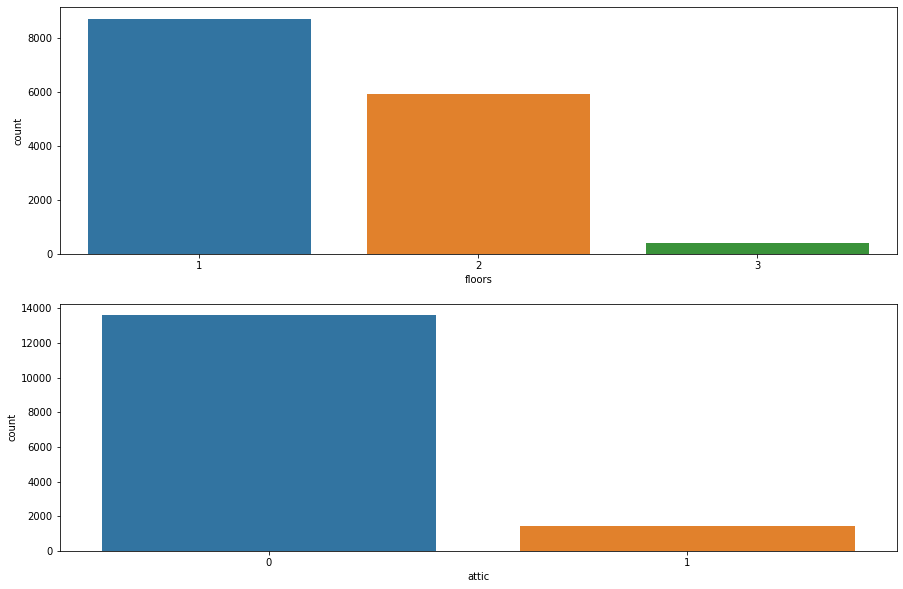

In [42]:
# 시각화 해보기 데이터량의 분포
fig, (ax1, ax2) = plt.subplots(2,1)
fig.set_size_inches(15,10)
sns.countplot(data = train, x = train['floors'], ax = ax1)
sns.countplot(data = train, x = train['attic'], ax = ax2)

<AxesSubplot:xlabel='attic', ylabel='price'>

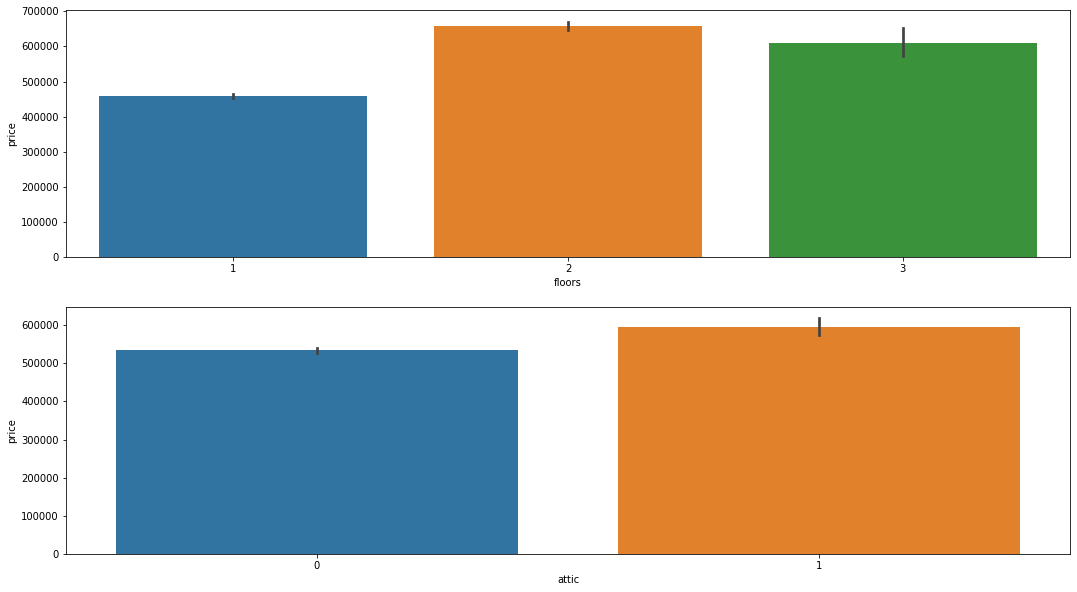

In [43]:
# 가격에 따른 floors
fig, (ax1,ax2) = plt.subplots(2,1)
fig.set_size_inches(18,10)
sns.barplot(data = train, x = 'floors', y = 'price', ax = ax1)
sns.barplot(data = train, x = 'attic', y = 'price', ax = ax2)

* 3층 집이 가장 비싼지 않은 것에 의아했다. 데이터량은 가장 적고 2층 데이터의 평균 가격보다 3층 데이터의 평균가격이 낮은데에는 위치의 이유도 있지 않을까라는 생각이 든다.
* 다락방이 있는 집일수록 값이 올라간다. <br>
이 그래프들을 보고 다락방의 유무에 따라 층 수가 가격에 어떠한 영향을 미치는지 궁금해졌다.

<AxesSubplot:xlabel='floors', ylabel='price'>

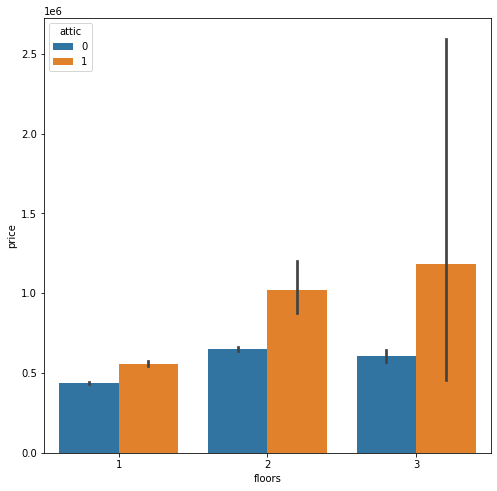

In [44]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,8)
sns.barplot(data = train, x = 'floors', y = 'price', hue = 'attic', ax = ax)

* 다락이 있는 집들은 층에 따라 가격이 올라간다. 하지만 다락방이 없는 집은 2층 집이 제일 가격이 높다.
* 다락방이 있으면 더 비싸다.<br>
따라서 test값에도 다락방의 유무 행을 추가해야겠다.

In [45]:
# test에도 다락방의 유무 행을 추가, 층수에서는 다락방을 뺀 후 정수화시켰다.
test['attic'] = np.zeros(test.shape[0])
test.loc[test['floors'] % 1 != 0, 'attic'] = 1

In [46]:
test['floors'] = test['floors'].astype('int')
test['attic'] = test['attic'].astype('int')

In [47]:
test.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,lat,long,sqft_living15,sqft_lot15,year,month,day,day_of_week,quarter,attic
0,3,2.25,2570,7242,2,0,0,3,7,2170,...,47.7210,-122.319,1690,7639,2014,12,9,1,4,0
1,4,3.00,1960,5000,1,0,0,5,7,1050,...,47.5208,-122.393,1360,5000,2014,12,9,1,4,0
2,4,4.50,5420,101930,1,0,0,3,11,3890,...,47.6561,-122.005,4760,101930,2014,5,12,0,2,0
3,3,1.00,1780,7470,1,0,0,3,7,1050,...,47.5123,-122.337,1780,8113,2015,4,15,2,2,0
4,3,2.50,1890,6560,2,0,0,3,7,1890,...,47.3684,-122.031,2390,7570,2015,3,12,3,1,0


### waterfront, view, condition,grade - 범주형 데이터 분석

In [48]:
train.waterfront.unique()

array([0, 1])

In [49]:
train.view.unique()

array([0, 3, 4, 2, 1])

In [50]:
train.condition.unique()

array([3, 4, 5, 2, 1])

In [51]:
train.grade.unique()

array([ 7,  6,  8,  9, 10, 11, 12,  5,  4,  3, 13,  1])

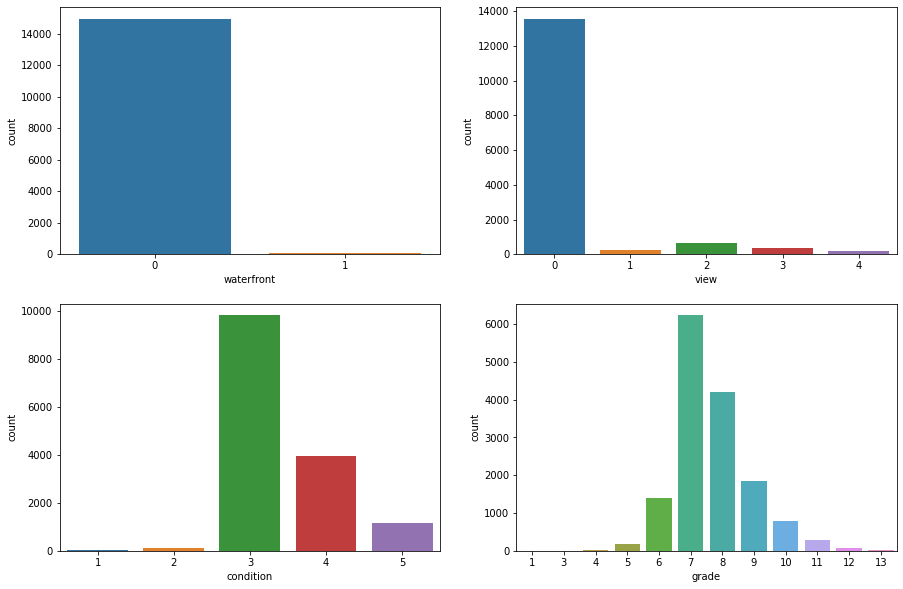

In [52]:
# 시각화 해보기 데이터량의 분포
columns = ['waterfront', 'view', 'condition', 'grade']
fig, ax = plt.subplots(2,2)
fig.set_size_inches(15,10)
for i in range(4):
    sns.countplot(data = train, x = train[columns[i]], ax = ax[i//2,i%2])


* 거의 대부분 판매된 집앞에는 바다나 강이 없는 것 같다
* view가 0인 집들이 매우 많은 것으로보아 제대로 평가가 안된 데이터인 것 같다. 
* condition이 보통인 집들이 제일 많아보인다
* 집의 등급도 중간이 제일 많아 보인다.

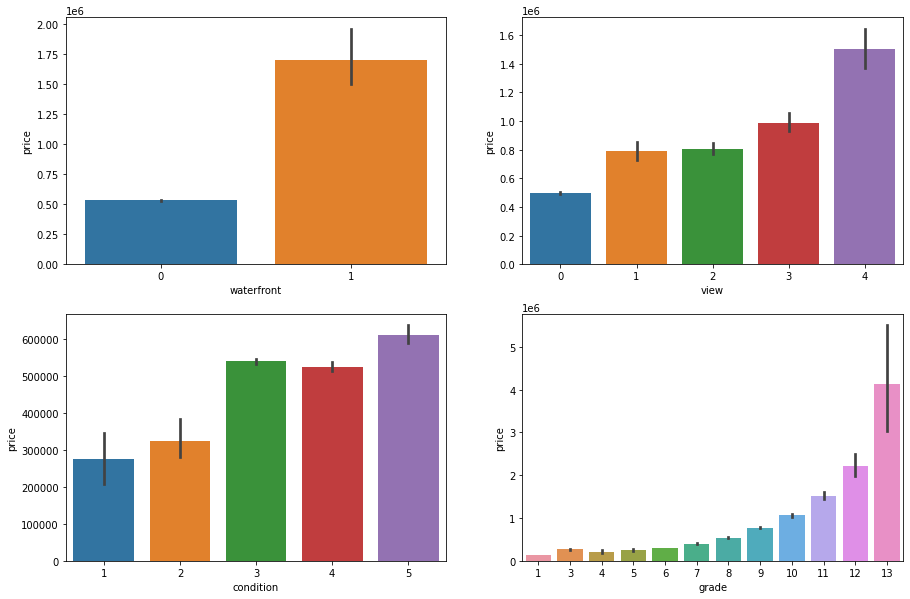

In [53]:
# 각 특징 별 가격
fig, ax = plt.subplots(2,2)
fig.set_size_inches(18,10)
fig.set_size_inches(15,10)
for i in range(4):
    sns.barplot(data = train, x = columns[i], y = 'price', ax = ax[i//2,i%2])


* 오션뷰/ 리버뷰인 집일수록 더 값이 비싸지는 특징을 보인다.
* 등급이 좋을수록 집 값이 비싸진다.
* condition에서 condition 3이 condition 4 보다 값이 더 비싼것을 볼 수 있는데 왜 그럴까?
    * 컨디션 3이 더 좋은 위치에 있다면 더 값이 비싸질 수도 있을 것 같다.

### 지하실 관련 평방 피트 데이터 분석

In [54]:
train.sqft_above.describe()

count    15035.000000
mean      1794.158164
std        831.738609
min        290.000000
25%       1190.000000
50%       1570.000000
75%       2230.000000
max       9410.000000
Name: sqft_above, dtype: float64

In [55]:
train.sqft_basement.describe()

count    15035.000000
mean       289.632059
std        440.663284
min          0.000000
25%          0.000000
50%          0.000000
75%        550.000000
max       4130.000000
Name: sqft_basement, dtype: float64

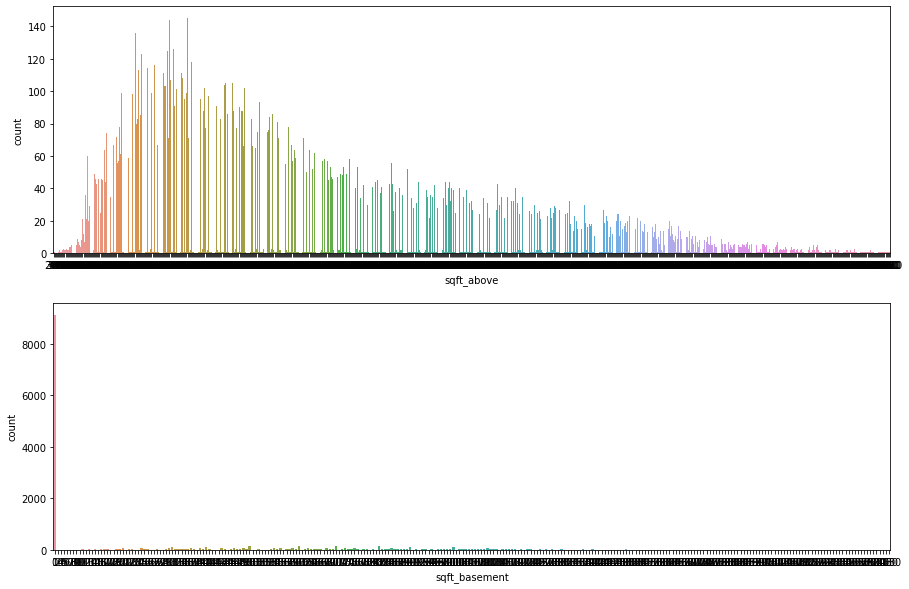

In [56]:
# 시각화 해보기 데이터량의 분포
columns = ['sqft_above', 'sqft_basement']
fig, ax = plt.subplots(2,1)
fig.set_size_inches(15,10)
for i in range(2):
    sns.countplot(data = train, x = train[columns[i]], ax = ax[i%2])

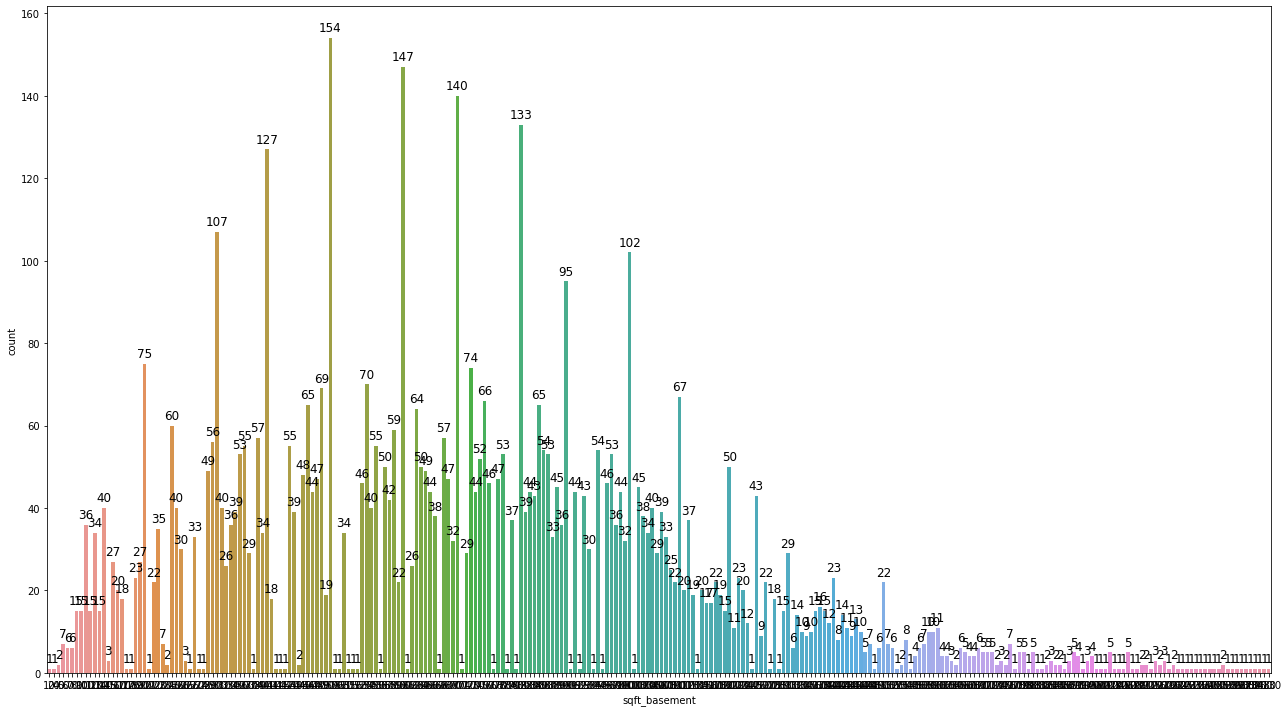

In [57]:
fig, ax2 = plt.subplots(1,1)
fig.set_size_inches(18,10)
graph = sns.countplot(data = train, x = train.loc[train['sqft_basement']>0,'sqft_basement'], ax = ax2)

# 막대 위에 실제 수치 추가
for p in graph.patches:
    graph.annotate(f'{p.get_height()}', 
                  (p.get_x() + p.get_width() / 2., p.get_height()), 
                  ha='center', va='center', 
                  xytext=(0, 10), 
                  textcoords='offset points',
                  fontsize=12, color='black')

plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='sqft_above', ylabel='price'>

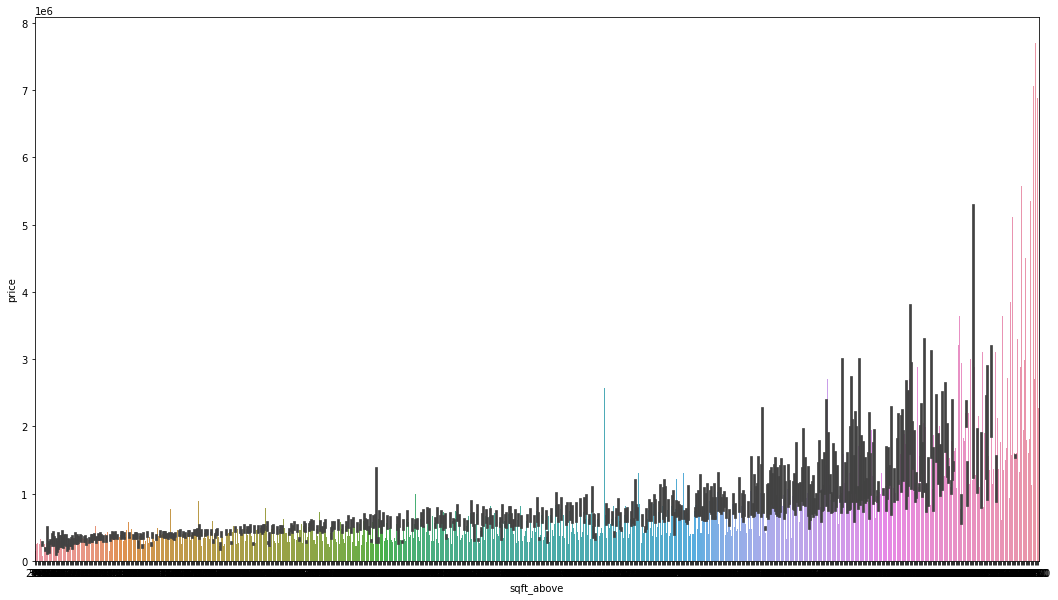

In [58]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(18,10)
sns.barplot(data = train, x ='sqft_above',y = 'price', ax = ax)

* 평방피트가 클수록 가격도 올라간다.

In [59]:
print(len(train.loc[train['sqft_basement'] == 0]))
print(train['sqft_basement'].shape)

9143
(15035,)


basement sqft가 0인데이터가 굉장히 많다. 지하실의 유무 특징을 만들어도 될것같다.

In [60]:
train['basement'] = np.zeros(train.shape[0])
train.loc[train['sqft_basement'] != 0, 'basement'] = 1
train['basement'] = train['basement'].astype('int')

In [61]:
train.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,long,sqft_living15,sqft_lot15,year,month,day,day_of_week,quarter,attic,basement
0,221900.0,3,1.00,1180,5650,1,0,0,3,7,...,-122.257,1340,5650,2014,10,13,0,4,0,0
1,180000.0,2,1.00,770,10000,1,0,0,3,6,...,-122.233,2720,8062,2015,2,25,2,1,0,0
2,510000.0,3,2.00,1680,8080,1,0,0,3,8,...,-122.045,1800,7503,2015,2,18,2,1,0,0
3,257500.0,3,2.25,1715,6819,2,0,0,3,7,...,-122.327,2238,6819,2014,6,27,4,2,0,0
4,291850.0,3,1.50,1060,9711,1,0,0,3,7,...,-122.315,1650,9711,2015,1,15,3,1,0,0


In [62]:
test['basement'] = np.zeros(test.shape[0])
test.loc[test['sqft_basement'] != 0, 'basement'] = 1
test['basement'] = test['basement'].astype('int')

In [63]:
test.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,long,sqft_living15,sqft_lot15,year,month,day,day_of_week,quarter,attic,basement
0,3,2.25,2570,7242,2,0,0,3,7,2170,...,-122.319,1690,7639,2014,12,9,1,4,0,1
1,4,3.00,1960,5000,1,0,0,5,7,1050,...,-122.393,1360,5000,2014,12,9,1,4,0,1
2,4,4.50,5420,101930,1,0,0,3,11,3890,...,-122.005,4760,101930,2014,5,12,0,2,0,1
3,3,1.00,1780,7470,1,0,0,3,7,1050,...,-122.337,1780,8113,2015,4,15,2,2,0,1
4,3,2.50,1890,6560,2,0,0,3,7,1890,...,-122.031,2390,7570,2015,3,12,3,1,0,0


<AxesSubplot:xlabel='basement', ylabel='price'>

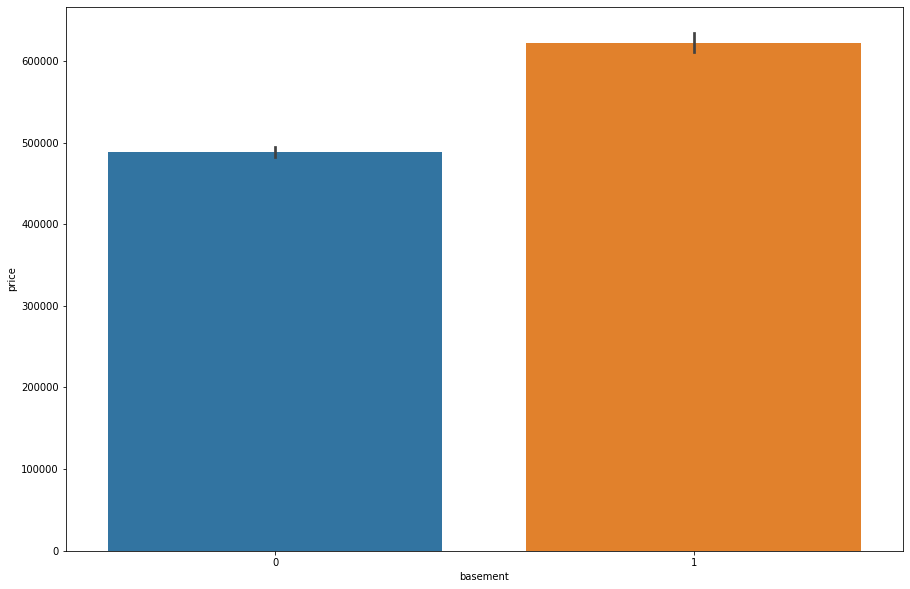

In [64]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(15,10)
sns.barplot(data = train, x = train['basement'], y = 'price', ax = ax)

지하실이 있는 집값이 더 비싼것으로 보인다.

### 집을 지은 연도, 재건축한 연도에 따른 데이터 + 2015년 기준 sqft 데이터 분석

In [65]:
train.yr_built.unique()

array([1955, 1933, 1987, 1995, 1963, 1965, 1942, 1927, 1977, 1900, 1979,
       1994, 1916, 1921, 1969, 1947, 1968, 1985, 1941, 1915, 1909, 2003,
       1929, 1981, 1930, 1904, 1996, 1984, 2014, 1922, 1966, 1950, 2008,
       1959, 1954, 1989, 2005, 1973, 1972, 1986, 1956, 2002, 1992, 1964,
       1952, 1925, 1961, 2006, 1988, 2001, 1962, 1939, 1967, 1975, 1910,
       1983, 1991, 1905, 1980, 1971, 2010, 1945, 1924, 1978, 1926, 1923,
       1990, 2000, 1976, 1949, 1999, 1901, 1993, 1948, 1920, 1997, 1957,
       2004, 1960, 1940, 1918, 1974, 1911, 1937, 1982, 1908, 1931, 1998,
       1928, 1943, 1907, 2013, 1953, 2012, 2007, 1912, 2011, 1917, 1958,
       1946, 1951, 1932, 1944, 2009, 1903, 1970, 1938, 1919, 1906, 1936,
       1913, 1902, 1914, 2015, 1935, 1934])

In [66]:
train.yr_renovated.unique()

array([   0, 2002, 1999, 1991, 1978, 2005, 2008, 2003, 1994, 1984, 1954,
       2014, 2011, 1974, 1983, 2013, 1990, 1957, 1977, 1981, 1995, 2000,
       1986, 1992, 2004, 2007, 1987, 2006, 1985, 1971, 1945, 1979, 1997,
       2010, 1969, 1948, 2009, 1970, 2015, 1989, 2001, 1968, 2012, 1963,
       1993, 1962, 1972, 1980, 1998, 1955, 1996, 1950, 1956, 1982, 1988,
       1940, 1946, 1975, 1964, 1958, 1976, 1973, 1967, 1965, 1944])

In [67]:
train.sqft_living15.describe()

count    15035.000000
mean      1992.754772
std        691.456442
min        399.000000
25%       1490.000000
50%       1850.000000
75%       2360.000000
max       6210.000000
Name: sqft_living15, dtype: float64

In [68]:
train.sqft_lot15.describe()

count     15035.000000
mean      12823.884935
std       27736.259787
min         651.000000
25%        5100.000000
50%        7610.000000
75%       10076.000000
max      871200.000000
Name: sqft_lot15, dtype: float64

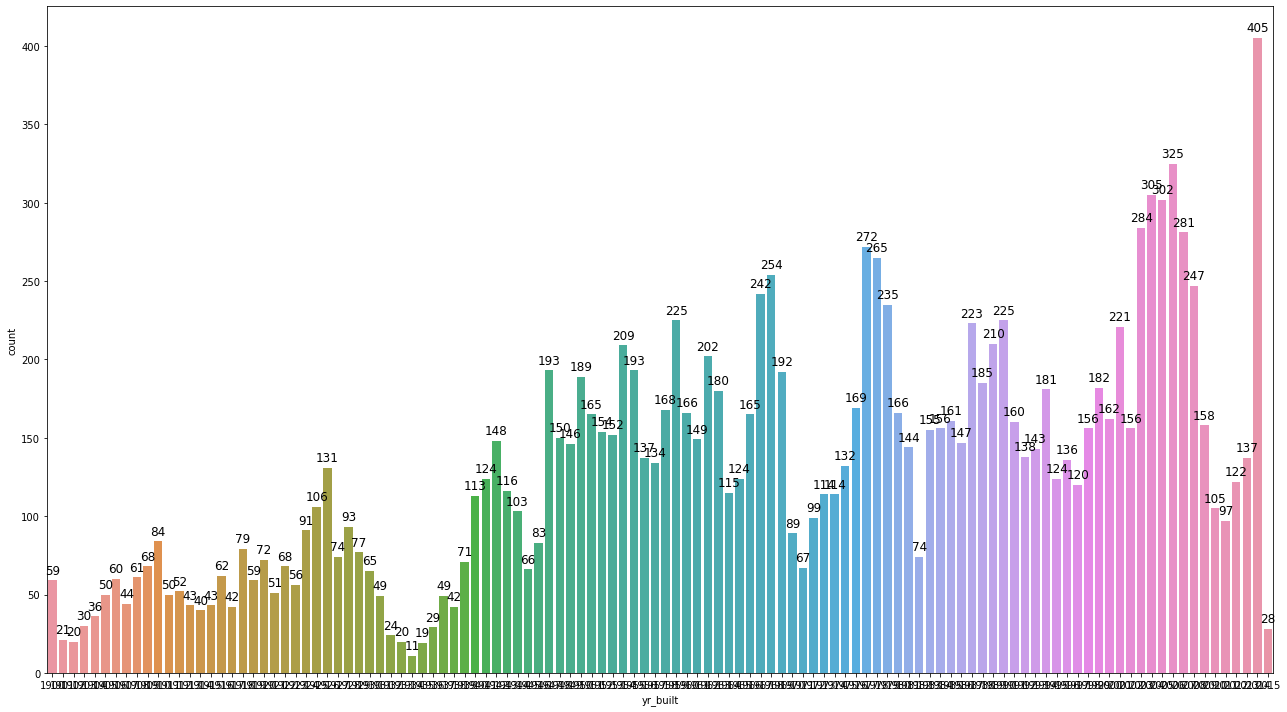

In [69]:
# 시각화 해보기 데이터량의 분포
# columns = ['yr_built', 'yr_renovated']
fig, ax1 = plt.subplots(1,1)
fig.set_size_inches(18,10)
graph = sns.countplot(data = train, x = train['yr_built'], ax = ax1)
for p in graph.patches:
    graph.annotate(f'{p.get_height()}', 
                  (p.get_x() + p.get_width() / 2., p.get_height()), 
                  ha='center', va='center', 
                  xytext=(0, 10), 
                  textcoords='offset points',
                  fontsize=12, color='black')

plt.tight_layout()
plt.show()


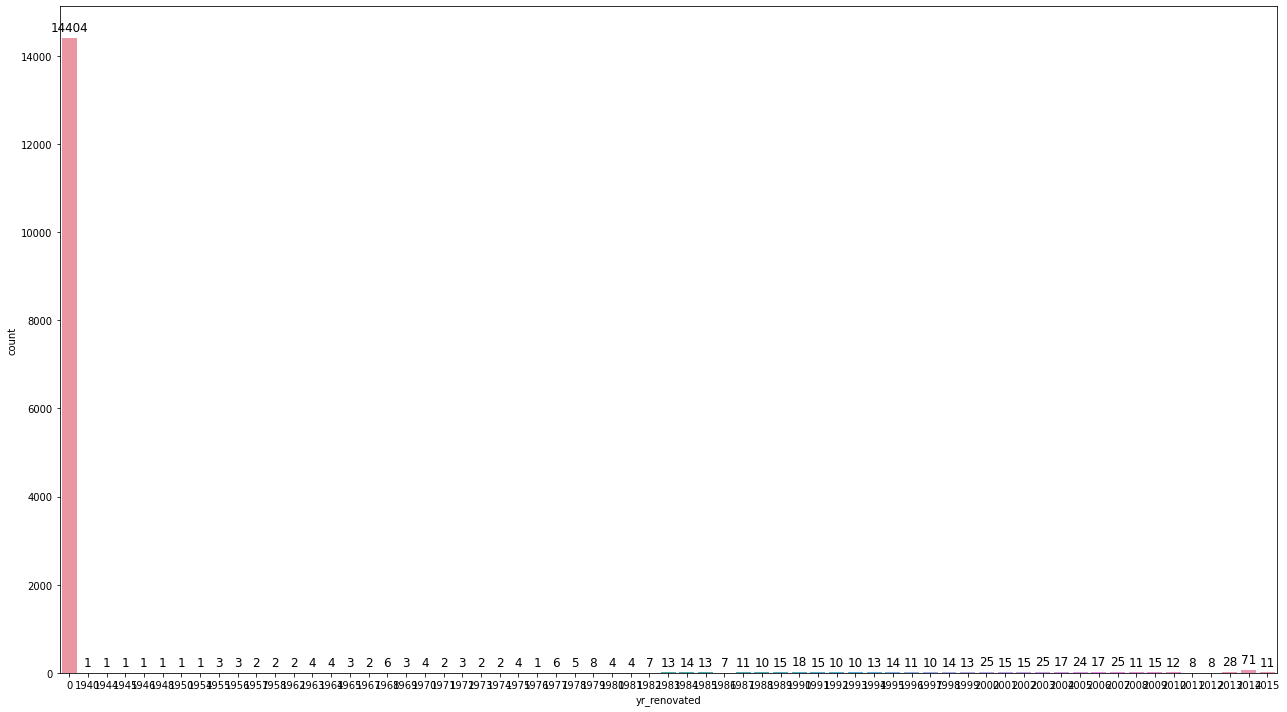

In [70]:
fig, ax2 = plt.subplots(1,1)
fig.set_size_inches(18,10)
graph = sns.countplot(data = train, x = train['yr_renovated'], ax = ax2)

for p in graph.patches:
    graph.annotate(f'{p.get_height()}', 
                  (p.get_x() + p.get_width() / 2., p.get_height()), 
                  ha='center', va='center', 
                  xytext=(0, 10), 
                  textcoords='offset points',
                  fontsize=12, color='black')

plt.tight_layout()
plt.show()


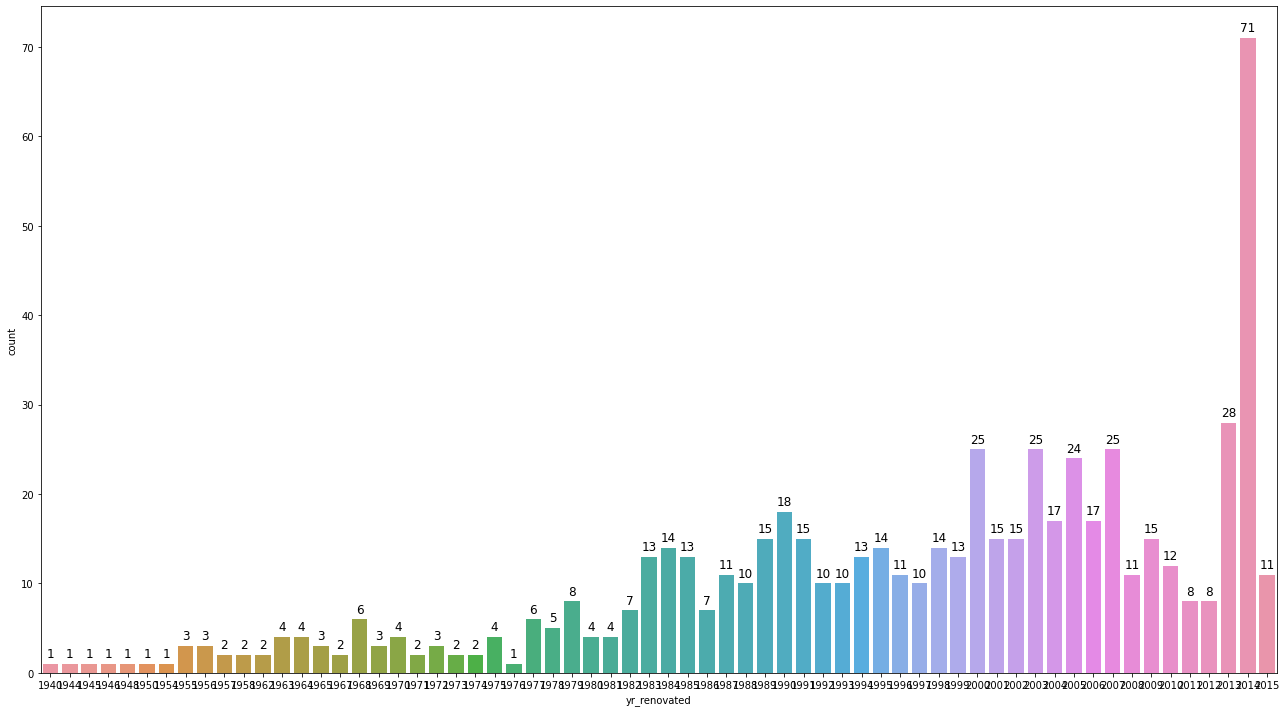

In [71]:
fig, ax2 = plt.subplots(1,1)
fig.set_size_inches(18,10)
graph = sns.countplot(data = train, x = train.loc[train['yr_renovated']>0,'yr_renovated'], ax = ax2)

# 막대 위에 실제 수치 추가
for p in graph.patches:
    graph.annotate(f'{p.get_height()}', 
                  (p.get_x() + p.get_width() / 2., p.get_height()), 
                  ha='center', va='center', 
                  xytext=(0, 10), 
                  textcoords='offset points',
                  fontsize=12, color='black')

plt.tight_layout()
plt.show()

재건축하지 않은 집들이 많다는 것을 알 수 있다.<br>
집의 나이를 따로 계산해서 집의 나이에 따른 가격을 확인해보려고한다.

In [72]:
# 재건축 여부를 먼저 알아본뒤
# 재건축 1: 판매년도 - 재건축년도
# 재건축 0: 판매년도 - 지어진년도

train['renovated'] = np.zeros(train.shape[0])
train.loc[train['yr_renovated']>0, 'renovated'] = 1
train['renovated'] = train['renovated'].astype('int') 
train['age'] = np.zeros(train.shape[0])
train.loc[train['renovated'] == 1, 'age'] = train['year'] - train['yr_renovated']
train.loc[train['renovated'] == 0, 'age'] = train['year'] - train['yr_built']
train['age'] = train['age'].astype('int')

In [73]:
# 재건축 여부를 먼저 알아본뒤
# 재건축 1: 판매년도 - 재건축년도
# 재건축 0: 판매년도 - 지어진년도

test['renovated'] = np.zeros(test.shape[0])
test.loc[train['yr_renovated']>0, 'renovated'] = 1
test['renovated'] = test['renovated'].astype('int') 
test['age'] = np.zeros(test.shape[0])
test.loc[test['renovated'] == 1, 'age'] = test['year'] - test['yr_renovated']
test.loc[test['renovated'] == 0, 'age'] = test['year'] - test['yr_built']
test['age'] = test['age'].astype('int')

In [74]:
train.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_lot15,year,month,day,day_of_week,quarter,attic,basement,renovated,age
0,221900.0,3,1.00,1180,5650,1,0,0,3,7,...,5650,2014,10,13,0,4,0,0,0,59
1,180000.0,2,1.00,770,10000,1,0,0,3,6,...,8062,2015,2,25,2,1,0,0,0,82
2,510000.0,3,2.00,1680,8080,1,0,0,3,8,...,7503,2015,2,18,2,1,0,0,0,28
3,257500.0,3,2.25,1715,6819,2,0,0,3,7,...,6819,2014,6,27,4,2,0,0,0,19
4,291850.0,3,1.50,1060,9711,1,0,0,3,7,...,9711,2015,1,15,3,1,0,0,0,52


<AxesSubplot:xlabel='renovated', ylabel='price'>

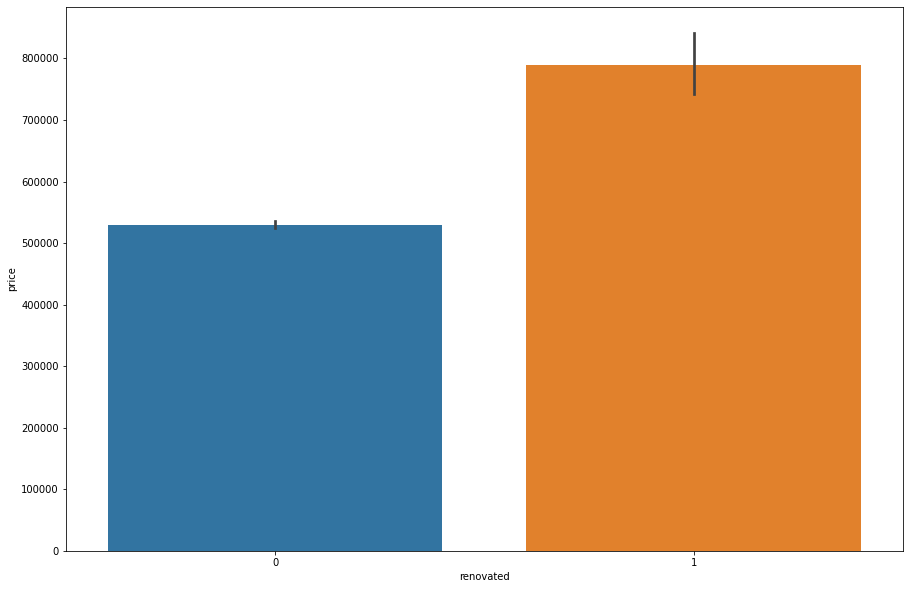

In [75]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(15,10)
sns.barplot(data = train, x = train['renovated'], y = 'price', ax = ax)

<AxesSubplot:xlabel='age', ylabel='price'>

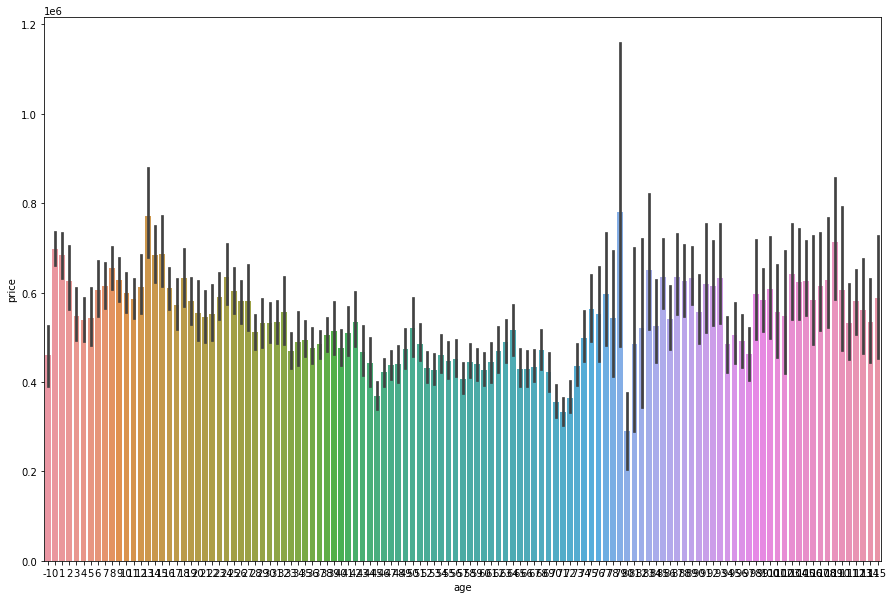

In [76]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(15,10)
sns.barplot(data = train, x = train['age'], y = 'price', ax = ax)

<AxesSubplot:xlabel='age', ylabel='price'>

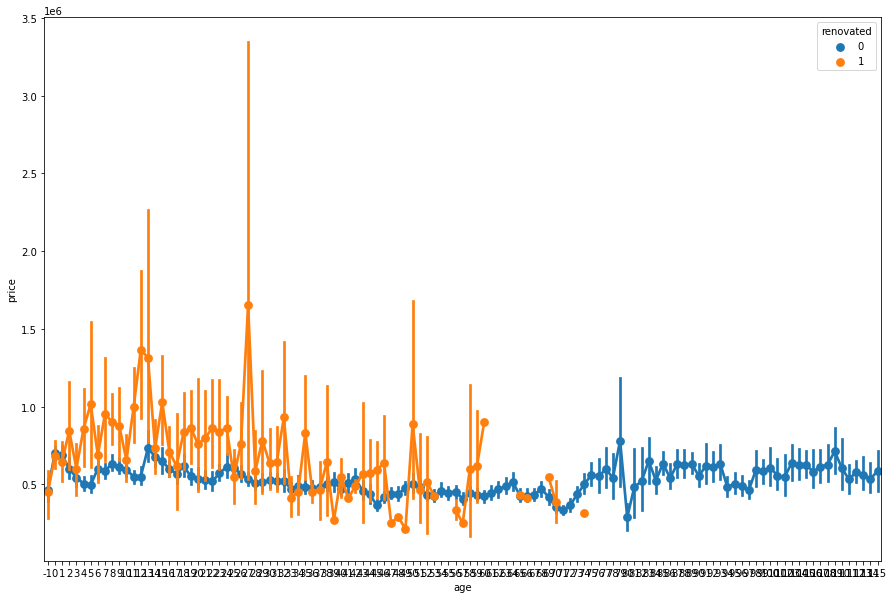

In [77]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(15,10)
sns.pointplot(data = train, x = train['age'], y = 'price', hue = 'renovated' ,ax = ax)

집나이와 가격에는 큰 상관관계는 없어보이지만 재건축이 된 집일수록 가격이 더 높다는 것은 알 수 있다.

In [78]:
check = train.loc[train['sqft_living'] != train['sqft_living15']]
check[['year','sqft_living', 'sqft_living15']]
check.loc[check['year'] == 2014][['year','sqft_living', 'sqft_living15']]

,year,sqft_living,sqft_living15
0,2014,1180,1340
3,2014,1715,2238
6,2014,1160,1330
7,2014,1430,1780
12,2014,1600,1610
...,...,...,...
15021,2014,4910,4560
15023,2014,2500,2530
15024,2014,3600,3550
15026,2014,3990,3370


In [79]:
check.loc[check['year'] == 2015][['year','sqft_living', 'sqft_living15']]

,year,sqft_living,sqft_living15
1,2015,770,2720
2,2015,1680,1800
4,2015,1060,1650
5,2015,3560,2210
9,2015,1810,1360
...,...,...,...
15022,2015,4170,3030
15025,2015,3410,2290
15028,2015,1425,1285
15031,2015,3510,2050


2014년도에 구매를 했을때는 2015년도 평방피트가 되지 않았으므로 2014년 평방피트는 그대로 놓고 2015년도에 구매한 집의 평방피트만 2015년도의 평방피트로 바꿔서 사용하는게 좋을 것이라고 생각한다.

In [80]:
train.loc[(train['year'] == 2015)&(train['sqft_living']!=train['sqft_living15']), 'sqft_living'] = train['sqft_living15']

In [81]:
check = train.loc[train['sqft_living'] != train['sqft_living15']]
check[['year','sqft_living', 'sqft_living15']]
check.loc[check['year'] == 2015][['year','sqft_living', 'sqft_living15']]

,year,sqft_living,sqft_living15


In [82]:
check = train.loc[train['sqft_lot'] != train['sqft_lot15']]
check[['year','sqft_lot', 'sqft_lot15']]
check.loc[check['year'] == 2014][['year','sqft_lot', 'sqft_lot15']]

,year,sqft_lot,sqft_lot15
7,2014,19901,12697
8,2014,9680,10208
11,2014,14040,14018
13,2014,9850,5095
16,2014,44867,20336
...,...,...,...
15026,2014,7838,6814
15027,2014,8088,8964
15029,2014,5536,5731
15032,2014,1131,1509


In [83]:
check.loc[check['year'] == 2015][['year','sqft_lot', 'sqft_lot15']]

,year,sqft_lot,sqft_lot15
1,2015,10000,8062
2,2015,8080,7503
5,2015,9796,8925
10,2015,5000,4000
14,2015,9774,8850
...,...,...,...
15018,2015,1488,1497
15022,2015,8142,7980
15028,2015,1179,1253
15031,2015,7200,6200


In [84]:
train.loc[(train['year'] == 2015)&(train['sqft_lot']!=train['sqft_lot15']), 'sqft_lot'] = train['sqft_lot15']

In [85]:
check = train.loc[train['sqft_lot'] != train['sqft_lot15']]
check[['year','sqft_lot', 'sqft_lot15']]
check.loc[check['year'] == 2015][['year','sqft_lot', 'sqft_lot15']]

,year,sqft_lot,sqft_lot15


In [86]:
check = test.loc[test['sqft_living'] != test['sqft_living15']]
check[['year','sqft_living', 'sqft_living15']]
check.loc[check['year'] == 2014][['year','sqft_living', 'sqft_living15']]

,year,sqft_living,sqft_living15
0,2014,2570,1690
1,2014,1960,1360
2,2014,5420,4760
5,2014,2270,2240
8,2014,1190,1390
...,...,...,...
6455,2014,1140,1210
6458,2014,1260,1310
6459,2014,2770,1810
6462,2014,3118,2673


In [87]:
check.loc[check['year'] == 2015][['year','sqft_living', 'sqft_living15']]

,year,sqft_living,sqft_living15
4,2015,1890,2390
7,2015,2570,2630
13,2015,1250,970
14,2015,2753,2680
16,2015,3150,1990
...,...,...,...
6457,2015,2780,2850
6460,2015,1190,1180
6464,2015,1490,1400
6465,2015,1310,1330


In [88]:
test.loc[(test['year'] == 2015)&(test['sqft_living']!=test['sqft_living15']), 'sqft_living'] = test['sqft_living15']

In [89]:
check = test.loc[test['sqft_living'] != test['sqft_living15']]
check[['year','sqft_living', 'sqft_living15']]
check.loc[check['year'] == 2015][['year','sqft_living', 'sqft_living15']]

,year,sqft_living,sqft_living15


In [90]:
check = test.loc[test['sqft_lot'] != test['sqft_lot15']]
check[['year','sqft_lot', 'sqft_lot15']]
check.loc[check['year'] == 2014][['year','sqft_lot', 'sqft_lot15']]

,year,sqft_lot,sqft_lot15
0,2014,7242,7639
5,2014,6300,7005
6,2014,6380,6235
8,2014,1265,1756
9,2014,34848,11467
...,...,...,...
6459,2014,3852,5641
6461,2014,981,1282
6462,2014,7866,6500
6463,2014,11968,11303


In [91]:
check.loc[check['year'] == 2015][['year','sqft_lot', 'sqft_lot15']]

,year,sqft_lot,sqft_lot15
3,2015,7470,8113
4,2015,6560,7570
7,2015,7173,6026
13,2015,5963,5100
14,2015,65005,72513
...,...,...,...
6456,2015,10584,18270
6460,2015,1200,1224
6464,2015,1126,1230
6465,2015,1294,1265


In [92]:
test.loc[(train['year'] == 2015)&(test['sqft_lot']!=test['sqft_lot15']), 'sqft_lot'] = test['sqft_lot15']

In [93]:
check = test.loc[test['sqft_lot'] != test['sqft_lot15']]
check[['year','sqft_lot', 'sqft_lot15']]
check.loc[check['year'] == 2015][['year','sqft_lot', 'sqft_lot15']]

,year,sqft_lot,sqft_lot15
3,2015,7470,8113
7,2015,7173,6026
13,2015,5963,5100
16,2015,9134,9133
17,2015,8550,6738
...,...,...,...
6442,2015,8797,12150
6446,2015,1381,4800
6453,2015,2642,2594
6456,2015,10584,18270


### 위도 경도 zipcode 데이터 분석

In [94]:
len(train.zipcode.unique())

70

<AxesSubplot:xlabel='zipcode', ylabel='count'>

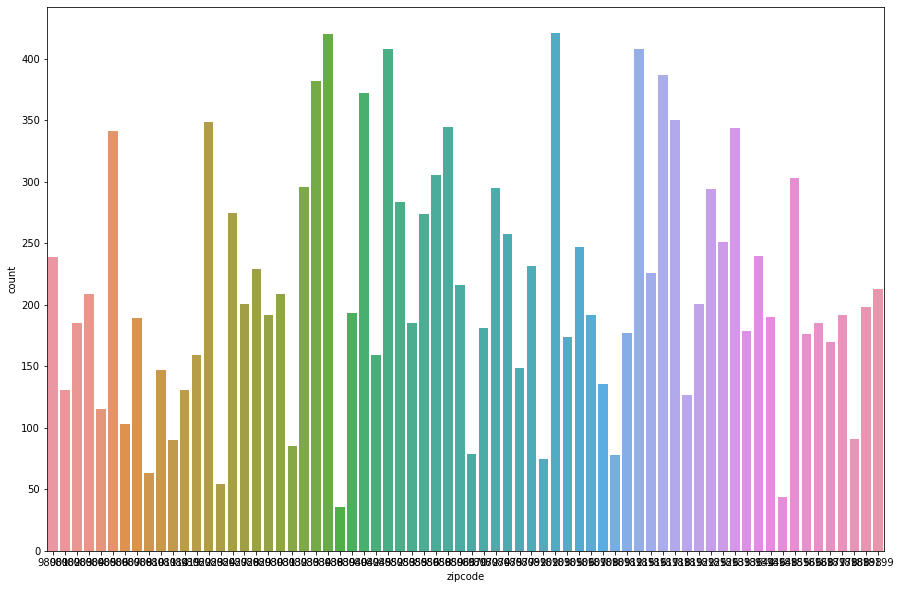

In [95]:
# zipcode에 따른 데이터량
fig, ax = plt.subplots(1,1)
fig.set_size_inches(15,10)
sns.countplot(data = train, x = train['zipcode'],ax = ax)

<AxesSubplot:xlabel='zipcode', ylabel='price'>

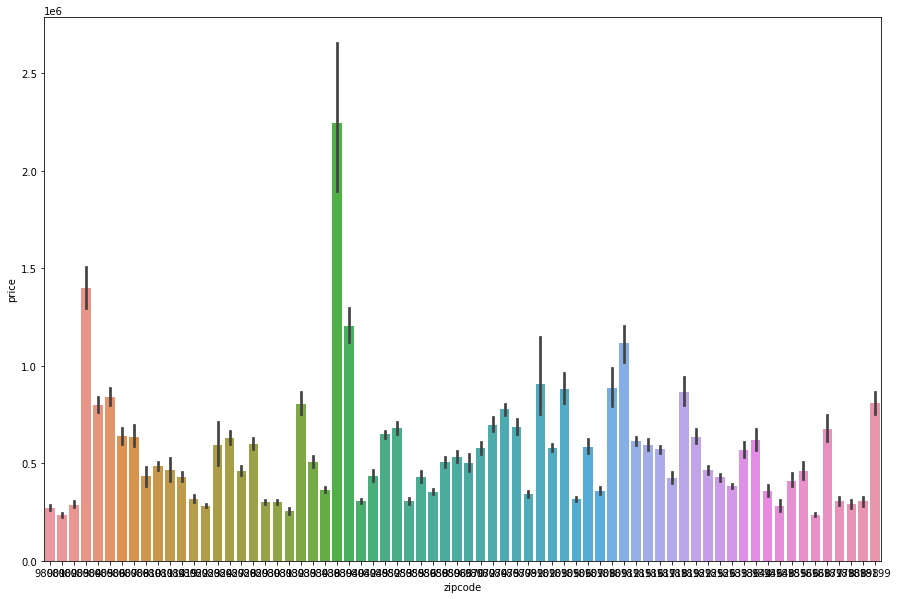

In [96]:
# zipcode에 따른 가격
fig, ax = plt.subplots(1,1)
fig.set_size_inches(15,10)
sns.barplot(data = train, x = train['zipcode'], y = 'price',ax = ax)

<AxesSubplot:xlabel='long', ylabel='lat'>

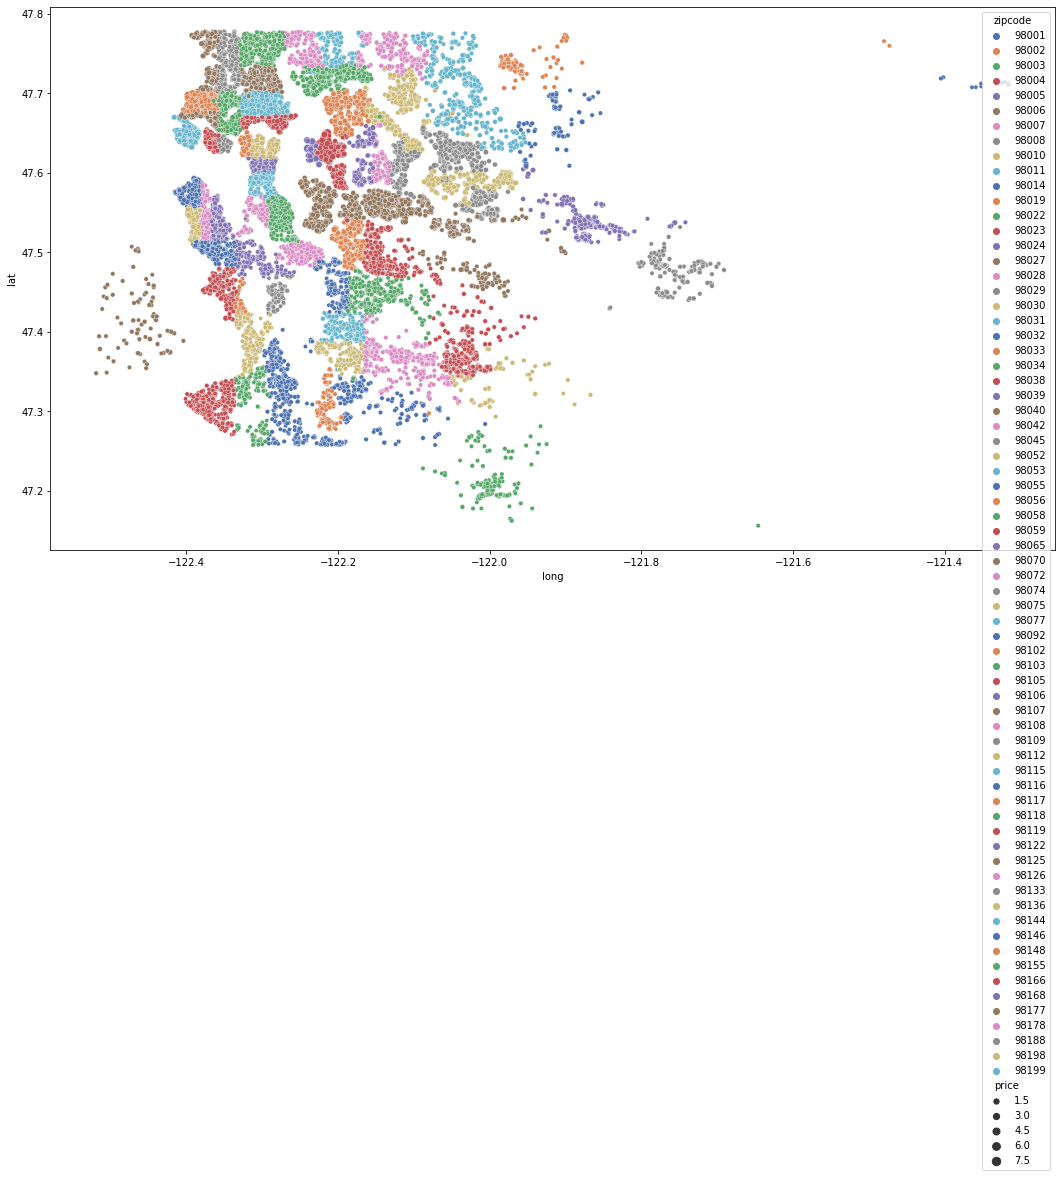

In [97]:
fig, ax1 = plt.subplots(1,1)
fig.set_size_inches(18,10)
sns.scatterplot(data = train, x = 'long', y = 'lat', hue = 'zipcode', size = 'price',palette="deep", ax = ax1)
# sns.scatterplot(data = train, x = 'bathrooms', y = 'price',hue = 'zipcode', ax = ax2)

<AxesSubplot:xlabel='long', ylabel='lat'>

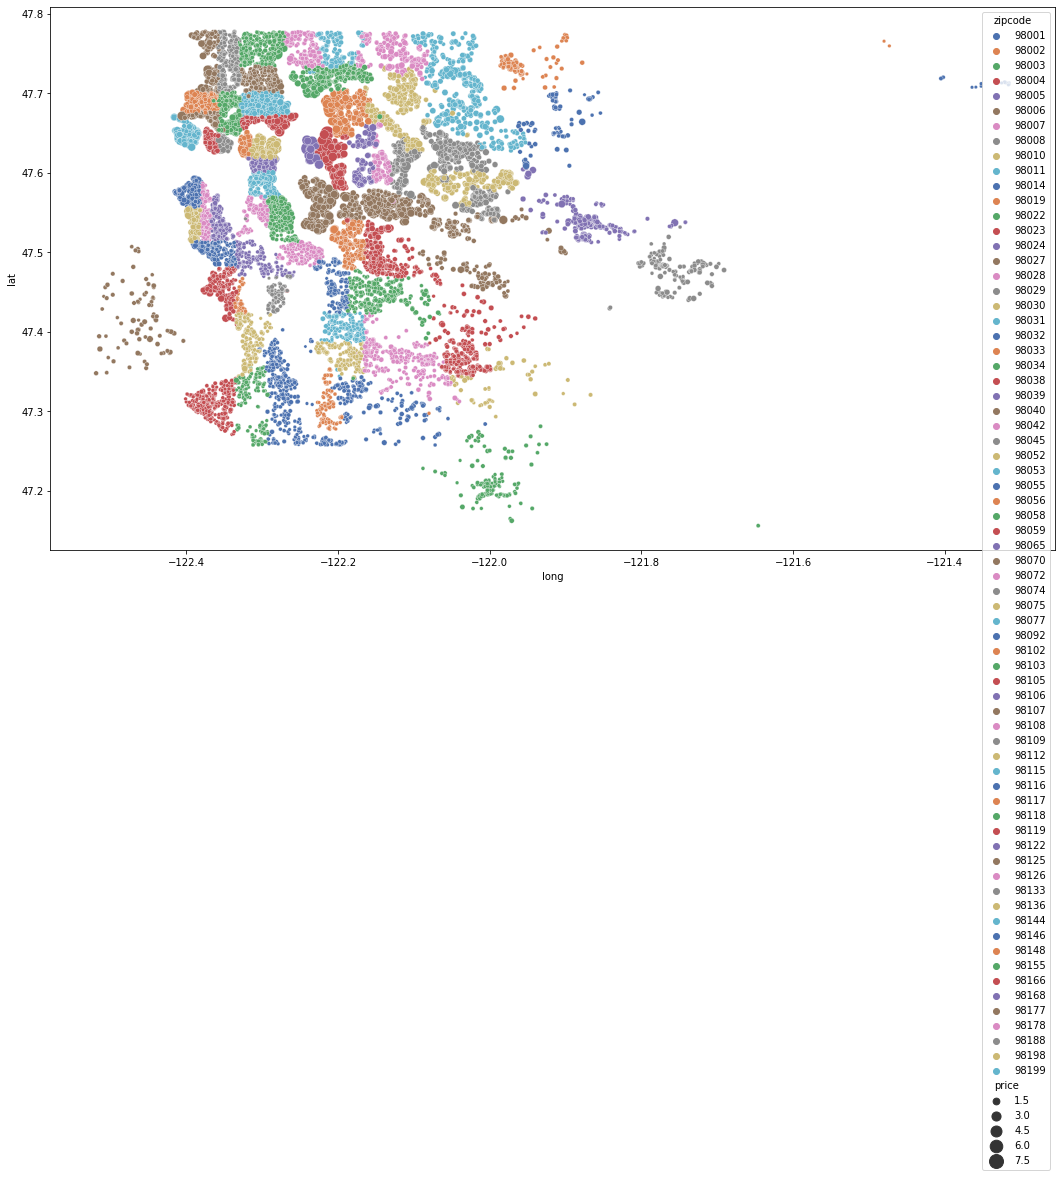

In [98]:
fig, ax1 = plt.subplots(1,1)
fig.set_size_inches(18,10)
sns.scatterplot(data = train, x = 'long', y = 'lat', hue = 'zipcode', size = 'price',sizes=(10, 200),palette="deep", ax = ax1)
# sns.scatterplot(data = train, x = 'bathrooms', y = 'price',hue = 'zipcode', ax = ax2)

특정 zipcode를 가진 지역의 집값이 높아보인다.

In [99]:
train_zip = list(sorted(train['zipcode'].unique()))
len(train_zip)

70

In [100]:
test_zip = list(sorted(test['zipcode'].unique()))
len(test_zip)

70

In [101]:
if train_zip == test_zip:
    print("Yes")
else:
    print("No")


Yes


#### * 위도 경도를 이용해서 도시이름을 구하려고했으나 시간이 너무 오래 걸려 하지 않음, 비지도학습 DBSCAN을 이용할까 하였지만 zipcode가 train과 test 데이터안에 똑같이 존재한다는 사실을 발견했기때문에 하지않기로 결심

<AxesSubplot:>

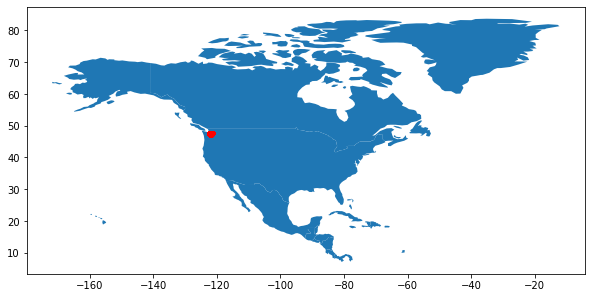

In [102]:
from geopandas import GeoDataFrame
import geopandas as gpd
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(train['long'], train['lat'])]
gdf = GeoDataFrame(train, geometry = geometry)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
america = world.loc[world['continent'] == 'North America']
gdf.plot(ax = america.plot(figsize = (10,6)), marker = 'o', color = 'red', markersize = 10)

* 북아메리카 지도를 이용해 경도위도 위치를 확인해 보니 미국의 북서부에 데이터들이 분포해있는 것으로 나타난다. Seattle같다.
* 북서부쪽이라면 경도 위도를 사용해 주, 도시데이터를 받아 사용하는 것이 더 효과적일 것 같다. 왜냐하면 경도위도 숫자만 가지고는 범위를 잡아서 값을 예측하기는 어려울 것 같기 때문이다.

In [103]:
from geopy.geocoders import Nominatim
# initialize Nominatim API
def find_city(data):
    geolocator = Nominatim(user_agent = 'geopiExercises')

    latitude = data['lat']
    longitude = data['long']
    states = []
    cities = []
    for lat, long in zip(latitude, longitude):
        print("loading...")
        location = geolocator.reverse(str(lat)+","+str(long))
        address = location.raw['address']
        states.append(address.get('state', ''))
        cities.append(address.get('city', ''))
        
    return states, cities

ModuleNotFoundError: No module named 'geopy'

In [104]:
from uszipcode import SearchEngine
def zco(x):
    search = SearchEngine()

    if pd.isnull(x):
        return None
    else:
        city = search.by_zipcode(int(x))['City']
        return city

ModuleNotFoundError: No module named 'uszipcode'

### heatmap을 통해 가격과 상관관계를 알아보려한다.

In [105]:
train_corr = train[['price','bedrooms', 'bathrooms','sqft_living', 'sqft_lot', 'floors','attic','waterfront','view','condition','grade','sqft_above','sqft_basement','basement','renovated','yr_built','yr_renovated','zipcode' ]]
corr = train_corr.corr()
corr

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,attic,waterfront,view,condition,grade,sqft_above,sqft_basement,basement,renovated,yr_built,yr_renovated,zipcode
price,1.000000,0.323672,0.525479,0.675510,0.091029,0.243731,0.048364,0.265738,0.400806,0.039740,0.667211,0.608577,0.322218,0.176706,0.140550,0.047290,0.140808,-0.051498
bedrooms,0.323672,1.000000,0.530548,0.542243,0.031040,0.167286,0.067169,-0.004819,0.085703,0.034885,0.375286,0.494867,0.315183,0.164975,0.022442,0.158799,0.022729,-0.162081
bathrooms,0.525479,0.530548,1.000000,0.702943,0.089378,0.527577,-0.113496,0.075452,0.187488,-0.125907,0.666278,0.688255,0.282642,0.157068,0.064998,0.503964,0.065423,-0.207500
sqft_living,0.675510,0.542243,0.702943,1.000000,0.178433,0.342560,-0.040636,0.109304,0.279661,-0.058955,0.739856,0.835231,0.377154,0.158746,0.057373,0.305945,0.057591,-0.213008
sqft_lot,0.091029,0.031040,0.089378,0.178433,1.000000,-0.001734,0.006902,0.031508,0.077824,-0.001601,0.119152,0.191192,0.023040,-0.033010,0.000159,0.061452,0.000078,-0.136255
floors,0.243731,0.167286,0.527577,0.342560,-0.001734,1.000000,-0.216995,0.027081,0.031201,-0.292450,0.477822,0.523970,-0.230465,-0.250307,-0.003564,0.582488,-0.003480,-0.099038
attic,0.048364,0.067169,-0.113496,-0.040636,0.006902,-0.216995,1.000000,0.012615,0.009464,0.139389,-0.095783,-0.023962,-0.013063,0.003207,0.048667,-0.385151,0.048612,0.154149
waterfront,0.265738,-0.004819,0.075452,0.109304,0.031508,0.027081,0.012615,1.000000,0.389669,0.011613,0.088061,0.081968,0.071576,0.034148,0.104605,-0.026523,0.104168,0.028632
view,0.400806,0.085703,0.187488,0.279661,0.077824,0.031201,0.009464,0.389669,1.000000,0.045255,0.247924,0.172693,0.265880,0.174340,0.107844,-0.061670,0.107605,0.089247
condition,0.039740,0.034885,-0.125907,-0.058955,-0.001601,-0.292450,0.139389,0.011613,0.045255,1.000000,-0.143599,-0.152856,0.175064,0.135725,-0.061876,-0.366590,-0.062342,0.001106


<AxesSubplot:title={'center':'Heatmap of train'}>

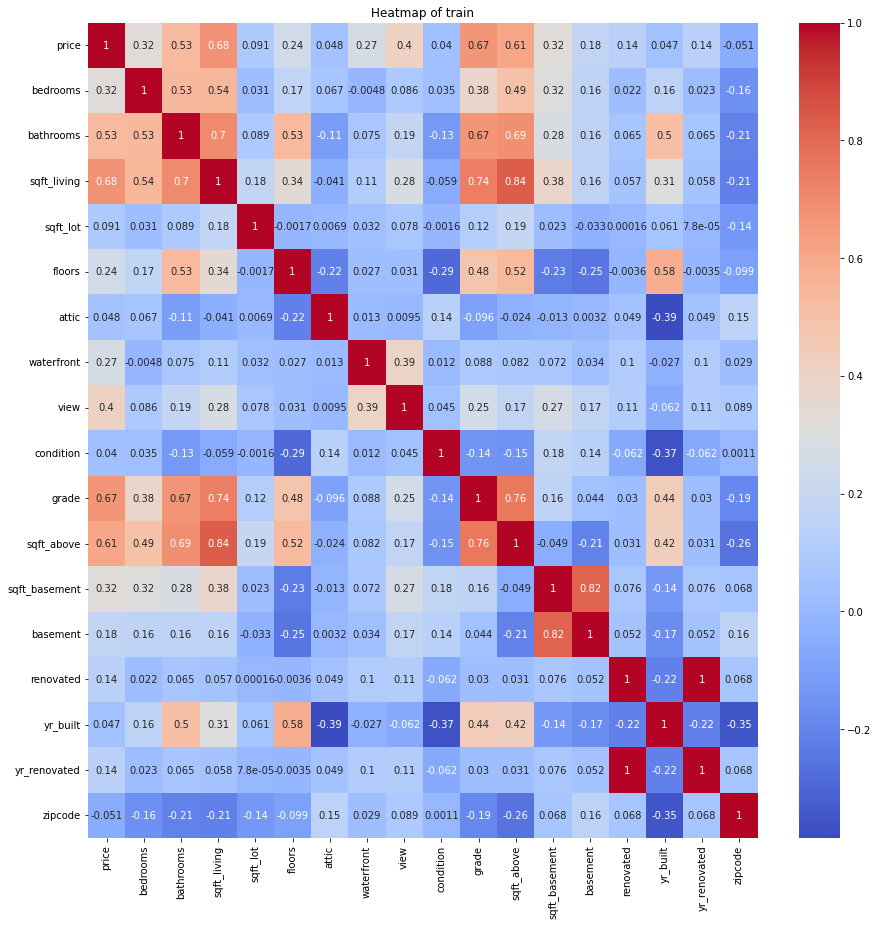

In [106]:
plt.figure(figsize=(15,15))
plt.title("Heatmap of train")
sns.heatmap(corr, annot = True, cmap = 'coolwarm')

가격과 상관관계가 높은 feature는 sqft_living, grade, sqft_basement로 나왔다.

### 정규화

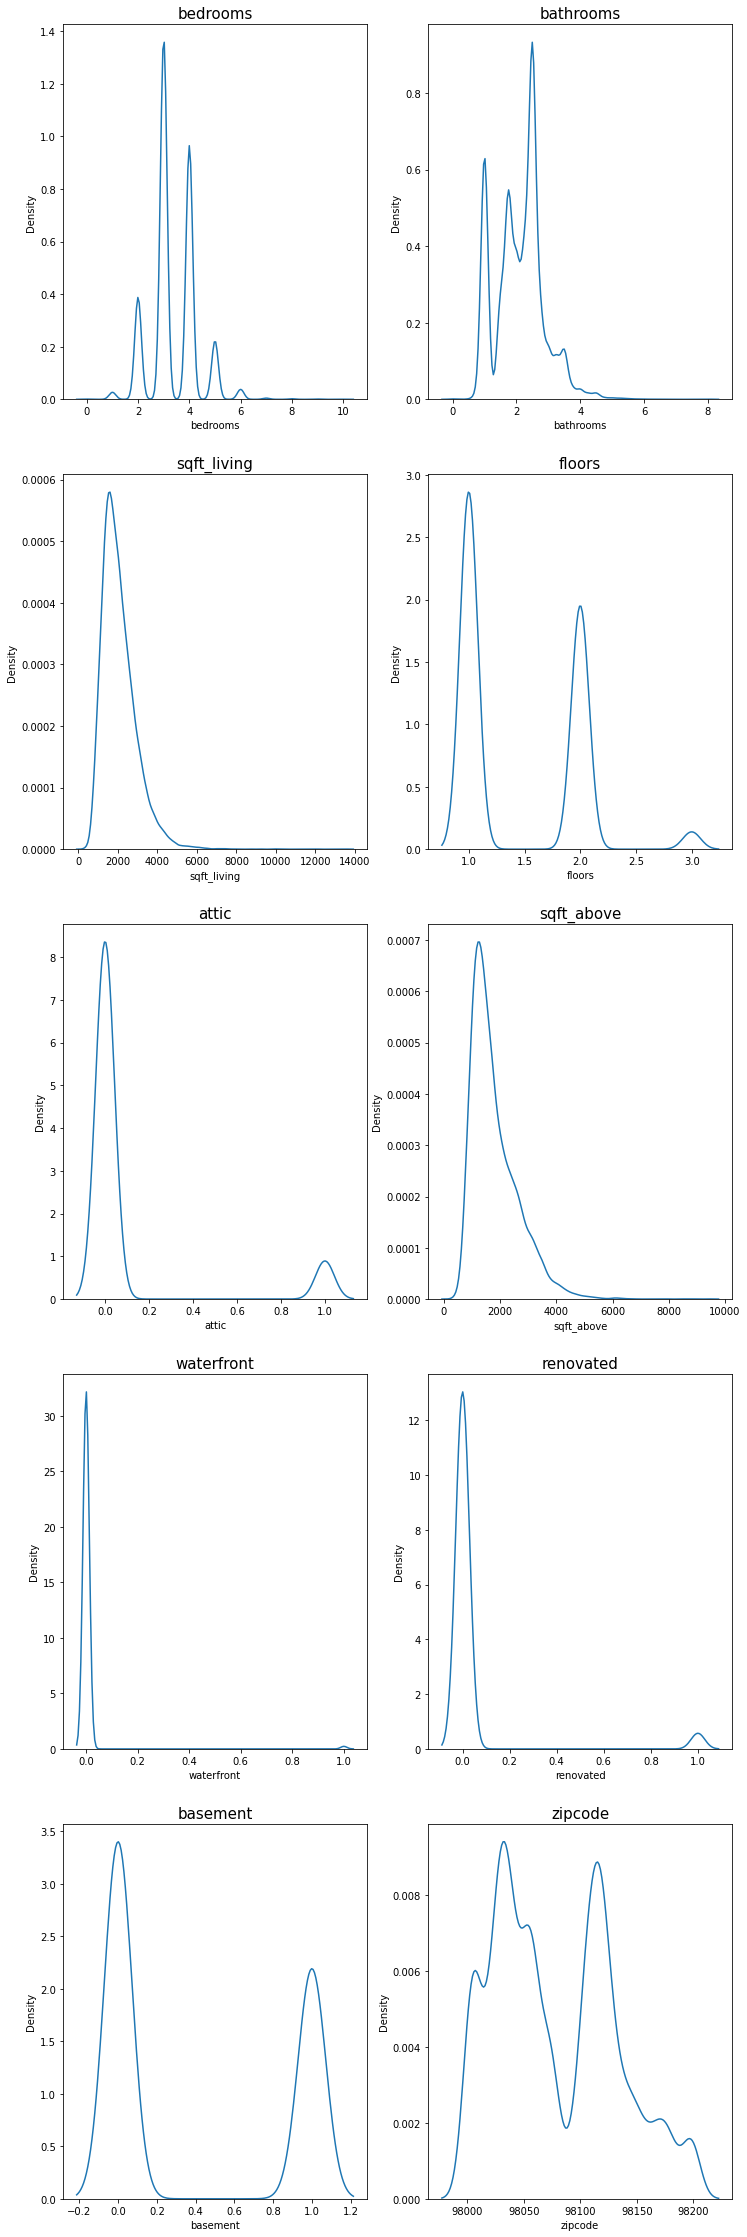

In [107]:
fig, ax = plt.subplots(5, 2, figsize=(12, 40))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 0
columns = ['bedrooms', 'bathrooms', 'sqft_living','floors','attic','sqft_above','waterfront','renovated','basement','zipcode']
for row in range(5):
    for col in range(2):
        sns.kdeplot(data=train[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1

In [108]:
cs = ['sqft_above', 'sqft_living']
for c in cs:
    train[c] = np.log1p(train[c].values)
    test[c] = np.log1p(test[c].values)

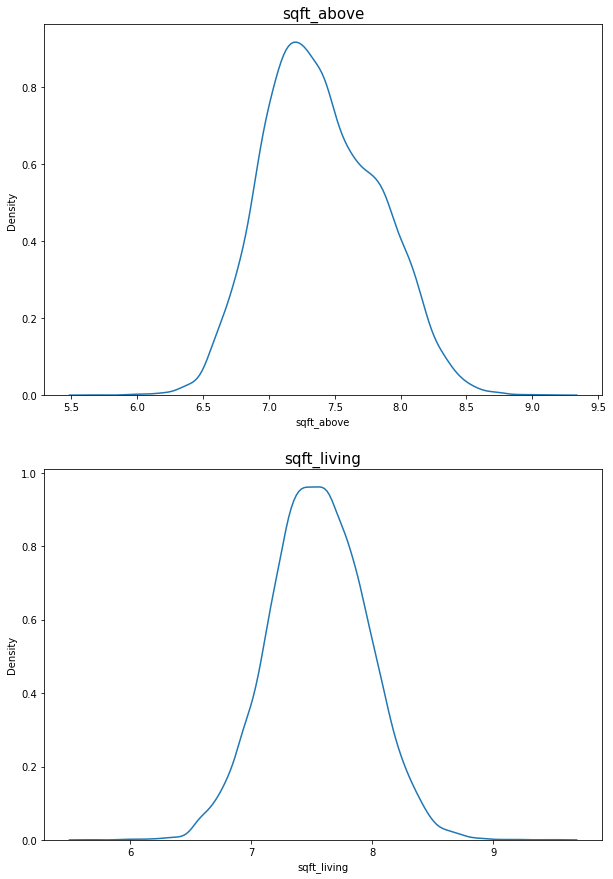

In [109]:
fig, ax = plt.subplots(2, 1, figsize=(10, 15))

count = 0
for row in range(2):

    sns.kdeplot(data = train[cs[count]], ax=ax[row])
    ax[row].set_title(cs[count], fontsize=15)
    count+=1
        

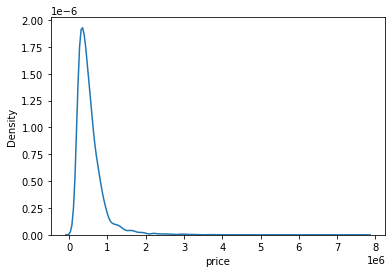

In [110]:
sns.kdeplot(train['price'])
plt.show()

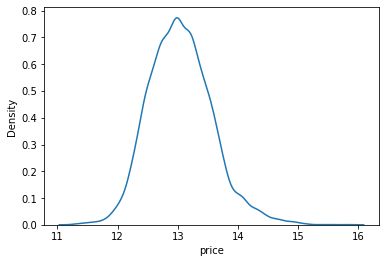

In [111]:
y_log_transformation = np.log1p(train['price'])

sns.kdeplot(y_log_transformation)
plt.show()

## Feature Selection

In [112]:
# 범주형 grade, condition, view는 one hot encoding을 해줘야한다.
hot = pd.get_dummies(train, columns = ['grade','condition','view'])

In [113]:
hot.columns.values

array(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'sqft_above', 'sqft_basement', 'yr_built',
       'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15',
       'sqft_lot15', 'year', 'month', 'day', 'day_of_week', 'quarter',
       'attic', 'basement', 'renovated', 'age', 'geometry', 'grade_1',
       'grade_3', 'grade_4', 'grade_5', 'grade_6', 'grade_7', 'grade_8',
       'grade_9', 'grade_10', 'grade_11', 'grade_12', 'grade_13',
       'condition_1', 'condition_2', 'condition_3', 'condition_4',
       'condition_5', 'view_0', 'view_1', 'view_2', 'view_3', 'view_4'],
      dtype=object)

In [114]:
train = hot

In [115]:
hot_t = pd.get_dummies(test, columns = ['grade','condition','view'])

In [116]:
test = hot_t

In [117]:
test['grade_1'] = np.zeros(test.shape[0])
test['grade_2'] = np.zeros(test.shape[0])

In [118]:
test.columns.values

array(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'sqft_above', 'sqft_basement', 'yr_built',
       'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15',
       'sqft_lot15', 'year', 'month', 'day', 'day_of_week', 'quarter',
       'attic', 'basement', 'renovated', 'age', 'grade_3', 'grade_4',
       'grade_5', 'grade_6', 'grade_7', 'grade_8', 'grade_9', 'grade_10',
       'grade_11', 'grade_12', 'grade_13', 'condition_1', 'condition_2',
       'condition_3', 'condition_4', 'condition_5', 'view_0', 'view_1',
       'view_2', 'view_3', 'view_4', 'grade_1', 'grade_2'], dtype=object)

In [119]:
features = ['bedrooms', 'bathrooms', 'sqft_living','floors','attic','sqft_above','waterfront','renovated','basement','zipcode', 'grade_1', 'grade_3',
       'grade_4', 'grade_5', 'grade_6', 'grade_7', 'grade_8', 'grade_9',
       'grade_10', 'grade_11', 'grade_12', 'grade_13', 'condition_1',
       'condition_2', 'condition_3', 'condition_4', 'condition_5',
       'view_0', 'view_1', 'view_2', 'view_3', 'view_4']

In [120]:
X = train[features]
y = np.log1p(train['price'])
test_X = test[features]

# Modeling

ensemble model: xgboost, lightgbm <br>
이유: 앙상블 모델이 여러 모델의 장점을 결합한 것으로 예측 성능을 향상시킬것이라고 생각함.<br>
metrics = RMSE<br>
이유: RMSE는 큰 오차에 더 큰 패널티를 부여하기때문.


In [121]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import xgboost
import lightgbm
import missingno
import sklearn
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
print(xgboost.__version__)
print(lightgbm.__version__)
print(missingno.__version__)
print(sklearn.__version__)

1.4.2
3.3.0
0.5.0
1.0


In [122]:
# Hyperparameter learning rate, 깊이, 반복횟수를 바꿔가며 train시켜보고자 한다.
random_state=2020
lightGBM_parameters = {'learning_rate': [0.01,0.05,0.1,0.5],
              'max_depth': [-1, 1, 5, 10],
             'num_iterations': [100,500,1000],}

boosting_parameters = {'eta': [0.01,0.05,0.1,0.5],
              'max_depth': [ 1, 5, 10]}
#              'num_boosted_rounds': [100,500,1000]}

In [123]:
#RMSE
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

# 한 가지 주의해야 할 것은, y_test나 y_pred는 
# 위에서 np.log1p()로 변환이 된 값이기 때문에 
# 원래 데이터의 단위에 맞게 되돌리기 위해 
# np.expm1()을 추가해야 한다는 점입니다.

In [124]:
def get_scores(model,train, y):
    scores = {}
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리
    # random_state를 사용하여 고정하고 train과 test 셋의 비율은 8:2로 합니다.
    train_X, val_X, train_y, val_y = train_test_split( X, y, test_size = 0.2, random_state = random_state)

    # 모델 학습
    model.fit(train_X, train_y)
    

    # 예측
    train_pred_y = model.predict(train_X)
    val_pred_y = model.predict(val_X)

    # 예측 결과의 rmse값 저장
    scores["train"] = rmse(train_y, train_pred_y)
    scores['val'] = rmse(val_y, val_pred_y)

    return scores

In [125]:
lightgbm_scores = {}
for a in lightGBM_parameters['learning_rate']:
    for b in lightGBM_parameters['max_depth']:
        for c in lightGBM_parameters['num_iterations']:
            s = f'lr:{a}, m_d:{b}, iter:{c}'
            print(s)
            lightgbm = LGBMRegressor(random_state=random_state, 
                                     learning_rate = a, 
                                     max_depth = b, 
                                     num_iterations = c)
            lightgbm_scores[s] = get_scores(lightgbm, X, y)
            t = lightgbm_scores[s]['train']
            v = lightgbm_scores[s]['val']
            print(f'train_rmse: {t}\n val_rmse: {v}')


lr:0.01, m_d:-1, iter:100
train_rmse: 284235.7413702802
 val_rmse: 261148.28464829776
lr:0.01, m_d:-1, iter:500
train_rmse: 150927.13357593378
 val_rmse: 148706.4581666474
lr:0.01, m_d:-1, iter:1000
train_rmse: 123551.02874863854
 val_rmse: 133932.2663726884
lr:0.01, m_d:1, iter:100
train_rmse: 341674.1072408734
 val_rmse: 311374.4302669907
lr:0.01, m_d:1, iter:500
train_rmse: 288813.0610023399
 val_rmse: 260144.63900998523
lr:0.01, m_d:1, iter:1000
train_rmse: 264513.65442643175
 val_rmse: 236733.308894644
lr:0.01, m_d:5, iter:100
train_rmse: 286046.5618626342
 val_rmse: 264785.26787025755
lr:0.01, m_d:5, iter:500
train_rmse: 170183.61773438277
 val_rmse: 170155.71552284944
lr:0.01, m_d:5, iter:1000
train_rmse: 135555.65511261515
 val_rmse: 144661.1821911064
lr:0.01, m_d:10, iter:100
train_rmse: 284074.10914467025
 val_rmse: 260975.08586232402
lr:0.01, m_d:10, iter:500
train_rmse: 153842.65150176332
 val_rmse: 152921.13421834982
lr:0.01, m_d:10, iter:1000
train_rmse: 123329.6442339930

lightgbm에서 제일 낮은 rmse 값 <br><br>
lr:0.05, m_d:10, iter:500<br>
train_rmse: 100008.93208891356<br>
 val_rmse: 127511.36242249672<br>

In [126]:
xgboosting_scores = {}
for a in boosting_parameters['eta']:
    for b in boosting_parameters['max_depth']:
#         for c in boosting_parameters['num_boosted_rounds']:
        s = f'lr:{a}, m_d:{b}'#', iter:{c}'
        print(s)
        xgboost = XGBRegressor(random_state=random_state, 
                                 eta = a, 
                                 max_depth = b)
#                                  num_boosted_rounds = c)
        xgboosting_scores[s] = get_scores(xgboost, X, y)
        t = xgboosting_scores[s]['train']
        v = xgboosting_scores[s]['val']
        print(f'train_rmse: {t}\n val_rmse: {v}')

lr:0.01, m_d:1
train_rmse: 655268.2917685561
 val_rmse: 637823.6791301401
lr:0.01, m_d:5
train_rmse: 655088.7494309227
 val_rmse: 637649.7596871492
lr:0.01, m_d:10
train_rmse: 655085.2177890915
 val_rmse: 637645.7253614732
lr:0.05, m_d:1
train_rmse: 300991.97332245973
 val_rmse: 272710.4296763987
lr:0.05, m_d:5
train_rmse: 198797.8145561217
 val_rmse: 194445.9172665543
lr:0.05, m_d:10
train_rmse: 147417.5016386598
 val_rmse: 171748.7771822353
lr:0.1, m_d:1
train_rmse: 263794.0666751395
 val_rmse: 236048.08236840056
lr:0.1, m_d:5
train_rmse: 130653.07346764446
 val_rmse: 148626.69341288053
lr:0.1, m_d:10
train_rmse: 72021.22302698609
 val_rmse: 136828.08869202776
lr:0.5, m_d:1
train_rmse: 199815.4943867372
 val_rmse: 186433.12988758823
lr:0.5, m_d:5
train_rmse: 79258.76790962782
 val_rmse: 132152.8080282877
lr:0.5, m_d:10
train_rmse: 14142.290659470478
 val_rmse: 153133.84943621504


In [141]:
xgboosting_scores

{'lr:0.01, m_d:1': {'train': 655268.2917685561, 'val': 637823.6791301401},
 'lr:0.01, m_d:5': {'train': 655088.7494309227, 'val': 637649.7596871492},
 'lr:0.01, m_d:10': {'train': 655085.2177890915, 'val': 637645.7253614732},
 'lr:0.05, m_d:1': {'train': 300991.97332245973, 'val': 272710.4296763987},
 'lr:0.05, m_d:5': {'train': 198797.8145561217, 'val': 194445.9172665543},
 'lr:0.05, m_d:10': {'train': 147417.5016386598, 'val': 171748.7771822353},
 'lr:0.1, m_d:1': {'train': 263794.0666751395, 'val': 236048.08236840056},
 'lr:0.1, m_d:5': {'train': 130653.07346764446, 'val': 148626.69341288053},
 'lr:0.1, m_d:10': {'train': 72021.22302698609, 'val': 136828.08869202776},
 'lr:0.5, m_d:1': {'train': 199815.4943867372, 'val': 186433.12988758823},
 'lr:0.5, m_d:5': {'train': 79258.76790962782, 'val': 132152.8080282877},
 'lr:0.5, m_d:10': {'train': 14142.290659470478, 'val': 153133.84943621504}}

xgboosting에서 가장 낮은 rmse
lr:0.5, m_d:5 <br>
train_rmse: 79258.76790962782<br>
 val_rmse: 132152.8080282877<br>

In [127]:
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)

In [137]:
l = get_scores(lightgbm, X, y)
print(l)

{'train': 121265.77329156216, 'val': 133769.56960982148}


In [132]:
x= get_scores(xgboost, X, y)

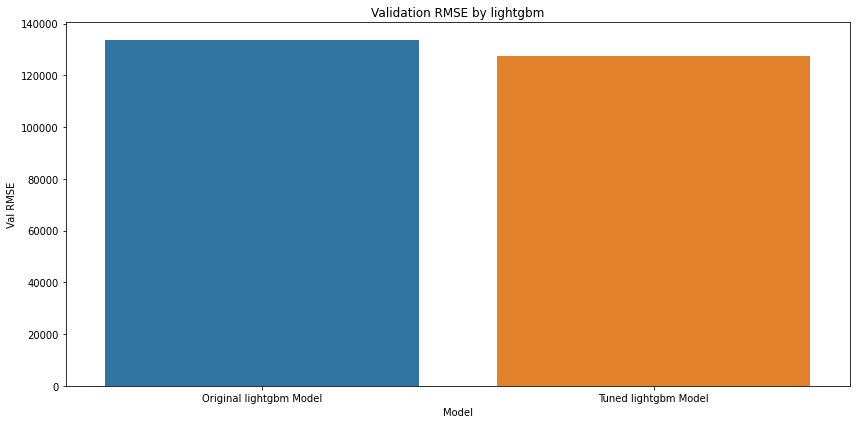

                     Model  Training RMSE       Val RMSE
0  Original lightgbm Model  121265.773292  133769.569610
1     Tuned lightgbm Model  100008.932089  127511.362422


In [138]:
# 원래 ensemble 모델과 tuned ensemble 모델 시각화
light_results = pd.DataFresults = pd.DataFrame({'Model': 
                                                ["Original lightgbm Model","Tuned lightgbm Model"], 
                                                "Training RMSE": [l["train"],lightgbm_scores["lr:0.05, m_d:10, iter:500"]["train"]], 
                                                "Val RMSE": [l["val"], lightgbm_scores["lr:0.05, m_d:10, iter:500"]["val"]]})
plt.figure(figsize=(12, 6))
ax1 = plt.subplot(1, 1, 1)
sns.barplot(x="Model", y="Val RMSE", data=light_results, ax=ax1)
plt.title('Validation RMSE by lightgbm')
plt.tight_layout()
plt.show()

print(light_results)

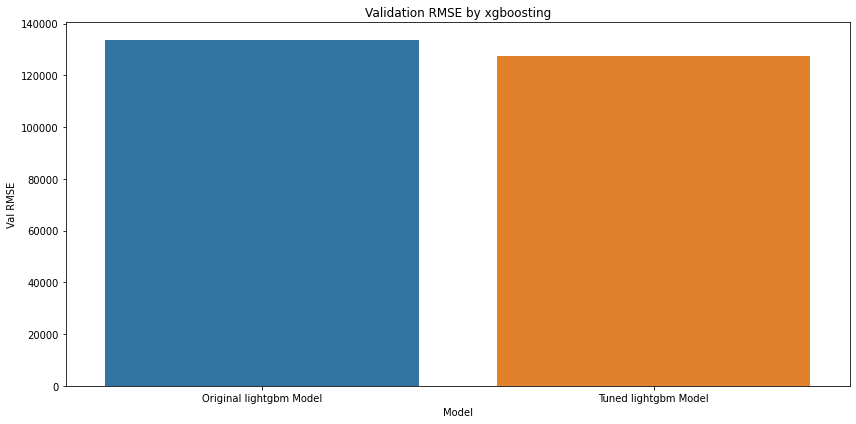

                    Model  Training RMSE       Val RMSE
0  Original xgboost Model   78576.802472  127928.014717
1     Tuned xgboost Model   79258.767910  132152.808028


In [143]:
xgboost_results = pd.DataFresults = pd.DataFrame({'Model': 
                                                ["Original xgboost Model","Tuned xgboost Model"], 
                                                "Training RMSE": [x["train"],xgboosting_scores["lr:0.5, m_d:5"]["train"]], 
                                                "Val RMSE": [x["val"], xgboosting_scores["lr:0.5, m_d:5"]["val"]]})
plt.figure(figsize=(12, 6))
ax1 = plt.subplot(1, 1, 1)
sns.barplot(x="Model", y="Val RMSE", data=light_results, ax=ax1)
plt.title('Validation RMSE by xgboosting')
plt.tight_layout()
plt.show()

print(xgboost_results)

In [144]:
best_model = LGBMRegressor(random_state=random_state, 
                                     learning_rate = 0.05, 
                                     max_depth = 10, 
                                     num_iterations = 500)

In [146]:
get_scores(best_model, X, y)

{'train': 100008.93208891356, 'val': 127511.36242249672}

In [147]:
prediction = best_model.predict(test_X)
prediction = np.expm1(prediction)

In [150]:
data_dir = "~/aiffel/kaggle_kakr_housing/data/data"
submission_path = join(data_dir, "sample_submission.csv")
submission = pd.read_csv(submission_path)
submission.head()



,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [151]:
submission['price'] = prediction
submission.head()


,id,price
0,15035,5.133064e+05
1,15036,5.285999e+05
2,15037,1.503399e+06
3,15038,2.903489e+05
4,15039,3.321738e+05


In [152]:
submission_csv_path = '{}/submission_{}.csv'.format(data_dir, "lightbgm" )
submission.to_csv(submission_csv_path, index=False)
print('{} saved!'.format(submission_csv_path))

~/aiffel/kaggle_kakr_housing/data/data/submission_lightbgm.csv saved!


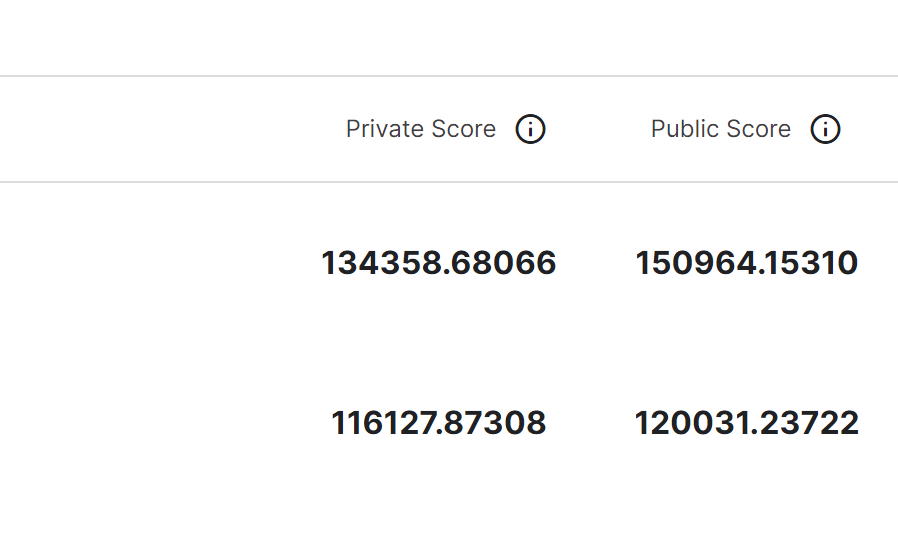

아쉽게도 목표점수에 도달하지 못했다.

데이터 전처리도 자세히 분석하고 모델도 여러개 돌려봤지만 더 좋은 성과를 내지 못했다. 어느 부분이 문제였는지 더 파헤쳐봐야겠다.